<a href="https://colab.research.google.com/github/AzKatrine/challenge_telecomX/blob/main/TelecomX_analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Extracão

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

# --- 1. Extração de dados ---
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json'
resposta = requests.get(url)
conteudo = resposta.content.decode('utf-8-sig')
dados_json = json.loads(conteudo)

# Normalização
df = pd.json_normalize(dados_json, sep='_')

# --- 2. Limpeza inicial e tratamento de tipos ---
# Renomear as colunas para minúsculas
df.columns = [col.lower() for col in df.columns]

# Tratar a coluna 'account_charges_total' que pode ter valores em branco
# A conversão com 'errors=coerce' transforma valores inválidos em NaN
df['account_charges_total'] = pd.to_numeric(df['account_charges_total'], errors='coerce')

# Remover linhas onde a coluna 'churn' está vazia (caso existam)
df = df[df['churn'].str.strip() != '']

# Verificar o estado do DataFrame após a limpeza
print("--- DataFrame após a limpeza inicial ---")
df.info()

# Preencher os valores nulos remanescentes em 'account_charges_total' com a mediana
initial_nulls = df['account_charges_total'].isnull().sum()
if initial_nulls > 0:
    median_charges_total = df['account_charges_total'].median()
    # Correção: Use a atribuição direta para modificar o DataFrame original
    df['account_charges_total'] = df['account_charges_total'].fillna(median_charges_total)
    print(f"\n✅ {initial_nulls} valores ausentes em 'account_charges_total' preenchidos com a mediana ({median_charges_total:.2f}).")
else:
    print("\n✅ Nenhum valor ausente encontrado em 'account_charges_total'.")

# Verificação final de valores nulos
print("\n--- Verificação final de valores nulos ---")
print(df.isnull().sum())

--- DataFrame após a limpeza inicial ---
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 7043 non-null   object 
 1   churn                      7043 non-null   object 
 2   customer_gender            7043 non-null   object 
 3   customer_seniorcitizen     7043 non-null   int64  
 4   customer_partner           7043 non-null   object 
 5   customer_dependents        7043 non-null   object 
 6   customer_tenure            7043 non-null   int64  
 7   phone_phoneservice         7043 non-null   object 
 8   phone_multiplelines        7043 non-null   object 
 9   internet_internetservice   7043 non-null   object 
 10  internet_onlinesecurity    7043 non-null   object 
 11  internet_onlinebackup      7043 non-null   object 
 12  internet_deviceprotection  7043 non-null   object 
 13  internet_tec

#🔧 Transformação

In [2]:
# --- 1. Padronização de valores nas colunas ---
print("--- Iniciando a padronização e transformação ---")

# Padronizar colunas de serviço de telefone e internet
# Substitui 'No phone service' e 'No internet service' por 'No'
for col in ['phone_multiplelines', 'internet_onlinesecurity',
            'internet_onlinebackup', 'internet_deviceprotection',
            'internet_techsupport', 'internet_streamingtv',
            'internet_streamingmovies']:
    if col in df.columns:
        df[col] = df[col].replace('No internet service', 'No').replace('No phone service', 'No')
        print(f"✅ Coluna '{col}' padronizada.")

--- Iniciando a padronização e transformação ---
✅ Coluna 'phone_multiplelines' padronizada.
✅ Coluna 'internet_onlinesecurity' padronizada.
✅ Coluna 'internet_onlinebackup' padronizada.
✅ Coluna 'internet_deviceprotection' padronizada.
✅ Coluna 'internet_techsupport' padronizada.
✅ Coluna 'internet_streamingtv' padronizada.
✅ Coluna 'internet_streamingmovies' padronizada.


In [3]:
# --- 2. Criação de novas colunas (Feature Engineering) ---
# Criar a coluna 'contas_diarias'
if 'account_charges_monthly' in df.columns:
    df['contas_diarias'] = df['account_charges_monthly'] / 30
    print(f"\n✅ Coluna 'contas_diarias' criada com sucesso.")


✅ Coluna 'contas_diarias' criada com sucesso.


In [4]:
# --- 3. Conversão de colunas categóricas para numéricas ---
# Converter colunas 'Yes'/'No' para 1/0
yes_no_cols = ['churn', 'customer_partner', 'customer_dependents', 'phone_phoneservice',
               'phone_multiplelines', 'internet_onlinesecurity', 'internet_onlinebackup',
               'internet_deviceprotection', 'internet_techsupport', 'internet_streamingtv',
               'internet_streamingmovies', 'account_paperlessbilling']

for col in yes_no_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})
        print(f"✅ Coluna '{col}' convertida para binário (Yes=1, No=0).")

# Converter 'customer_gender' para binário
if 'customer_gender' in df.columns:
    df['customer_gender'] = df['customer_gender'].map({'Female': 1, 'Male': 0})
    print("✅ Coluna 'customer_gender' convertida para binário (Female=1, Male=0).")

# Aplicar One-Hot Encoding nas colunas restantes
ohe_cols = ['internet_internetservice', 'account_contract', 'account_paymentmethod']
existing_ohe_cols = [col for col in ohe_cols if col in df.columns]

if existing_ohe_cols:
    df = pd.get_dummies(df, columns=existing_ohe_cols, drop_first=True, dtype=int)
    print(f"\n✅ One-Hot Encoding aplicado às colunas: {existing_ohe_cols}.")
    print("Novas colunas binárias foram criadas.")

✅ Coluna 'churn' convertida para binário (Yes=1, No=0).
✅ Coluna 'customer_partner' convertida para binário (Yes=1, No=0).
✅ Coluna 'customer_dependents' convertida para binário (Yes=1, No=0).
✅ Coluna 'phone_phoneservice' convertida para binário (Yes=1, No=0).
✅ Coluna 'phone_multiplelines' convertida para binário (Yes=1, No=0).
✅ Coluna 'internet_onlinesecurity' convertida para binário (Yes=1, No=0).
✅ Coluna 'internet_onlinebackup' convertida para binário (Yes=1, No=0).
✅ Coluna 'internet_deviceprotection' convertida para binário (Yes=1, No=0).
✅ Coluna 'internet_techsupport' convertida para binário (Yes=1, No=0).
✅ Coluna 'internet_streamingtv' convertida para binário (Yes=1, No=0).
✅ Coluna 'internet_streamingmovies' convertida para binário (Yes=1, No=0).
✅ Coluna 'account_paperlessbilling' convertida para binário (Yes=1, No=0).
✅ Coluna 'customer_gender' convertida para binário (Female=1, Male=0).

✅ One-Hot Encoding aplicado às colunas: ['internet_internetservice', 'account_cont

In [5]:
# --- 4. Verificação final ---
print("\n--- Verificação Final do DataFrame ---")
df.info()
print("\n--- Transformação e padronização concluídas! 🎉 ---")


--- Verificação Final do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   customerid                                     7043 non-null   object 
 1   churn                                          7043 non-null   int64  
 2   customer_gender                                7043 non-null   int64  
 3   customer_seniorcitizen                         7043 non-null   int64  
 4   customer_partner                               7043 non-null   int64  
 5   customer_dependents                            7043 non-null   int64  
 6   customer_tenure                                7043 non-null   int64  
 7   phone_phoneservice                             7043 non-null   int64  
 8   phone_multiplelines                            7043 non-null   int64  
 9   internet_onlinese

In [6]:
print("--- Iniciando a Tradução e Renomeação de Colunas ---")

# Dicionário de tradução e renomeação unificado para todas as colunas
renaming_map = {
    'customerid': 'id_cliente',
    'churn': 'churn',
    'customer_gender': 'genero',
    'customer_seniorcitizen': 'cidadao_senior',
    'customer_partner': 'possui_parceiro',
    'customer_dependents': 'possui_dependentes',
    'customer_tenure': 'meses_de_contrato',
    'phone_phoneservice': 'servico_telefone',
    'phone_multiplelines': 'multiplas_linhas',
    'internet_internetservice': 'servico_internet',
    'internet_onlinesecurity': 'seguranca_online',
    'internet_onlinebackup': 'backup_online',
    'internet_deviceprotection': 'protecao_dispositivo',
    'internet_techsupport': 'suporte_tecnico',
    'internet_streamingtv': 'streaming_tv',
    'internet_streamingmovies': 'streaming_filmes',
    'account_contract': 'tipo_contrato',
    'account_paperlessbilling': 'fatura_online',
    'account_paymentmethod': 'metodo_pagamento',
    'account_charges_monthly': 'gastos_mensais',
    'account_charges_total': 'gastos_totais',
    'contas_diarias': 'gastos_diarios',
    'internet_internetservice_Fiber optic': 'internet_fibra_optica',
    'internet_internetservice_No': 'internet_sem_servico',
    'account_contract_One year': 'contrato_anual',
    'account_contract_Two year': 'contrato_dois_anos',
    'account_paymentmethod_Credit card (automatic)': 'pagamento_cartao_credito_auto',
    'account_paymentmethod_Electronic check': 'pagamento_cheque_eletronico',
    'account_paymentmethod_Mailed check': 'pagamento_cheque_correio'
}

# Renomeia todas as colunas existentes no dicionário
df.rename(columns=renaming_map, inplace=True)

print("✅ Colunas renomeadas com sucesso para nomes mais compreensíveis em português.")

print("\n--- Novas Colunas do DataFrame ---")
print(df.columns.tolist())

print("\n--- Primeiras 5 linhas do DataFrame com as colunas renomeadas: ---")
print(df.head())

print("\n--- Tradução e Renomeação Concluídas com Sucesso! ✨ ---")

--- Iniciando a Tradução e Renomeação de Colunas ---
✅ Colunas renomeadas com sucesso para nomes mais compreensíveis em português.

--- Novas Colunas do DataFrame ---
['id_cliente', 'churn', 'genero', 'cidadao_senior', 'possui_parceiro', 'possui_dependentes', 'meses_de_contrato', 'servico_telefone', 'multiplas_linhas', 'seguranca_online', 'backup_online', 'protecao_dispositivo', 'suporte_tecnico', 'streaming_tv', 'streaming_filmes', 'fatura_online', 'gastos_mensais', 'gastos_totais', 'gastos_diarios', 'internet_fibra_optica', 'internet_sem_servico', 'contrato_anual', 'contrato_dois_anos', 'pagamento_cartao_credito_auto', 'pagamento_cheque_eletronico', 'pagamento_cheque_correio']

--- Primeiras 5 linhas do DataFrame com as colunas renomeadas: ---
   id_cliente  churn  genero  cidadao_senior  possui_parceiro  \
0  0002-ORFBO      0       1               0                1   
1  0003-MKNFE      0       0               0                0   
2  0004-TLHLJ      1       0               0     

In [7]:
print("--- Gerando Legenda para Valores Binários ---")

# Dicionário unificado para todas as legendas
binary_legend = {
    'churn': {1: 'Sim', 0: 'Não'},
    'possui_parceiro': {1: 'Sim', 0: 'Não'},
    'possui_dependentes': {1: 'Sim', 0: 'Não'},
    'servico_telefone': {1: 'Sim', 0: 'Não'},
    'multiplas_linhas': {1: 'Sim', 0: 'Não'},
    'seguranca_online': {1: 'Sim', 0: 'Não'},
    'backup_online': {1: 'Sim', 0: 'Não'},
    'protecao_dispositivo': {1: 'Sim', 0: 'Não'},
    'suporte_tecnico': {1: 'Sim', 0: 'Não'},
    'streaming_tv': {1: 'Sim', 0: 'Não'},
    'streaming_filmes': {1: 'Sim', 0: 'Não'},
    'fatura_online': {1: 'Sim', 0: 'Não'},
    'genero': {1: 'Feminino', 0: 'Masculino'},
    'cidadao_senior': {1: 'Sim (>= 65 anos)', 0: 'Não (< 65 anos)'},
    'internet_fibra_optica': {1: 'Sim (Fibra Óptica)', 0: 'Não (outros ou sem serviço)'},
    'internet_sem_servico': {1: 'Sim (Sem Serviço de Internet)', 0: 'Não (tem algum serviço)'},
    'contrato_anual': {1: 'Sim (Contrato Anual)', 0: 'Não (outro tipo de contrato)'},
    'contrato_dois_anos': {1: 'Sim (Contrato Dois Anos)', 0: 'Não (outro tipo de contrato)'},
    'pagamento_cartao_credito_auto': {1: 'Sim (Cartão de Crédito Automático)', 0: 'Não (outra forma)'},
    'pagamento_cheque_eletronico': {1: 'Sim (Cheque Eletrônico)', 0: 'Não (outra forma)'},
    'pagamento_cheque_correio': {1: 'Sim (Cheque via Correio)', 0: 'Não (outra forma)'}
}

print("\n--- Legenda Completa dos Valores Binários: ---")
for col, mapping in binary_legend.items():
    if col in df.columns:
        print(f"\nColuna: **{col}**")
        for value, meaning in mapping.items():
            print(f"  - `{value}`: {meaning}")

print("\n--- Geração da Legenda Concluída! ---")

--- Gerando Legenda para Valores Binários ---

--- Legenda Completa dos Valores Binários: ---

Coluna: **churn**
  - `1`: Sim
  - `0`: Não

Coluna: **possui_parceiro**
  - `1`: Sim
  - `0`: Não

Coluna: **possui_dependentes**
  - `1`: Sim
  - `0`: Não

Coluna: **servico_telefone**
  - `1`: Sim
  - `0`: Não

Coluna: **multiplas_linhas**
  - `1`: Sim
  - `0`: Não

Coluna: **seguranca_online**
  - `1`: Sim
  - `0`: Não

Coluna: **backup_online**
  - `1`: Sim
  - `0`: Não

Coluna: **protecao_dispositivo**
  - `1`: Sim
  - `0`: Não

Coluna: **suporte_tecnico**
  - `1`: Sim
  - `0`: Não

Coluna: **streaming_tv**
  - `1`: Sim
  - `0`: Não

Coluna: **streaming_filmes**
  - `1`: Sim
  - `0`: Não

Coluna: **fatura_online**
  - `1`: Sim
  - `0`: Não

Coluna: **genero**
  - `1`: Feminino
  - `0`: Masculino

Coluna: **cidadao_senior**
  - `1`: Sim (>= 65 anos)
  - `0`: Não (< 65 anos)

Coluna: **internet_fibra_optica**
  - `1`: Sim (Fibra Óptica)
  - `0`: Não (outros ou sem serviço)

Coluna: **inte

#📊 Carga e análise

In [8]:
print("--- Iniciando a Análise Descritiva dos Dados ---")

## 1. Análise Descritiva de Colunas Numéricas
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

if 'id_cliente' in numeric_cols:
    numeric_cols.remove('id_cliente')

if numeric_cols:
    print("\n## 1. Análise Descritiva de Colunas Numéricas")
    print(df[numeric_cols].describe())
else:
    print("\n## 1. Análise Descritiva de Colunas Numéricas")
    print("Nenhuma coluna numérica encontrada para análise descritiva.")

print("\n", "-"*40, "\n")

--- Iniciando a Análise Descritiva dos Dados ---

## 1. Análise Descritiva de Colunas Numéricas
             churn       genero  cidadao_senior  possui_parceiro  \
count  7043.000000  7043.000000     7043.000000      7043.000000   
mean      0.265370     0.495244        0.162147         0.483033   
std       0.441561     0.500013        0.368612         0.499748   
min       0.000000     0.000000        0.000000         0.000000   
25%       0.000000     0.000000        0.000000         0.000000   
50%       0.000000     0.000000        0.000000         0.000000   
75%       1.000000     1.000000        0.000000         1.000000   
max       1.000000     1.000000        1.000000         1.000000   

       possui_dependentes  meses_de_contrato  servico_telefone  \
count         7043.000000        7043.000000       7043.000000   
mean             0.299588          32.371149          0.903166   
std              0.458110          24.559481          0.295752   
min              0.000000  

In [9]:
## 2. Análise de Frequência de Colunas Categóricas/Binárias
binary_or_ohe_cols = [
    'churn', 'genero', 'cidadao_senior', 'possui_parceiro', 'possui_dependentes',
    'servico_telefone', 'multiplas_linhas', 'seguranca_online', 'backup_online',
    'protecao_dispositivo', 'suporte_tecnico', 'streaming_tv',
    'streaming_filmes', 'fatura_online', 'internet_fibra_optica',
    'internet_sem_servico', 'contrato_anual', 'contrato_dois_anos',
    'pagamento_cartao_credito_auto', 'pagamento_cheque_eletronico',
    'pagamento_cheque_correio'
]

# Filtra apenas as colunas que existem no DataFrame
existing_binary_ohe_cols = [col for col in binary_or_ohe_cols if col in df.columns]

if existing_binary_ohe_cols:
    print("\n## 2. Análise de Frequência de Colunas Categóricas/Binárias")
    for col in sorted(existing_binary_ohe_cols):
        print(f"\n--- Frequência da Coluna: '{col}' ---")
        print(df[col].value_counts())
        print(df[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
else:
    print("\n## 2. Análise de Frequência de Colunas Categóricas/Binárias")
    print("Nenhuma coluna categórica/binária encontrada para análise de frequência.")

print("\n", "-"*40, "\n")


## 2. Análise de Frequência de Colunas Categóricas/Binárias

--- Frequência da Coluna: 'backup_online' ---
backup_online
0    4614
1    2429
Name: count, dtype: int64
backup_online
0    65.51%
1    34.49%
Name: proportion, dtype: object

--- Frequência da Coluna: 'churn' ---
churn
0    5174
1    1869
Name: count, dtype: int64
churn
0    73.46%
1    26.54%
Name: proportion, dtype: object

--- Frequência da Coluna: 'cidadao_senior' ---
cidadao_senior
0    5901
1    1142
Name: count, dtype: int64
cidadao_senior
0    83.79%
1    16.21%
Name: proportion, dtype: object

--- Frequência da Coluna: 'contrato_anual' ---
contrato_anual
0    5570
1    1473
Name: count, dtype: int64
contrato_anual
0    79.09%
1    20.91%
Name: proportion, dtype: object

--- Frequência da Coluna: 'contrato_dois_anos' ---
contrato_dois_anos
0    5348
1    1695
Name: count, dtype: int64
contrato_dois_anos
0    75.93%
1    24.07%
Name: proportion, dtype: object

--- Frequência da Coluna: 'fatura_online' ---
fatura_onl

In [10]:
## 3. Visão Geral do DataFrame
print("\n## 3. Visão Geral do DataFrame")
print("\n--- Informações do DataFrame (dtypes e contagem de não-nulos) ---")
df.info()
print("\n--- Primeiras 5 linhas do DataFrame ---")
print(df.head())

print("\n--- Análise Descritiva Concluída! 🎉 ---")


## 3. Visão Geral do DataFrame

--- Informações do DataFrame (dtypes e contagem de não-nulos) ---
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id_cliente                     7043 non-null   object 
 1   churn                          7043 non-null   int64  
 2   genero                         7043 non-null   int64  
 3   cidadao_senior                 7043 non-null   int64  
 4   possui_parceiro                7043 non-null   int64  
 5   possui_dependentes             7043 non-null   int64  
 6   meses_de_contrato              7043 non-null   int64  
 7   servico_telefone               7043 non-null   int64  
 8   multiplas_linhas               7043 non-null   int64  
 9   seguranca_online               7043 non-null   int64  
 10  backup_online                  7043 non-null   int64  
 11  protecao_dispo

In [11]:
# Célula 1: Verificação de Unicidade do ID do Cliente
print("\n## 3. Verificação de Unicidade do ID do Cliente")
if 'id_cliente' in df.columns:
    num_unique_ids = df['id_cliente'].nunique()
    total_rows = len(df)
    print(f"Número de IDs de cliente únicos: {num_unique_ids}")
    print(f"Total de linhas no DataFrame: {total_rows}")
    if num_unique_ids == total_rows:
        print("✅ Todos os IDs de cliente são únicos.")
    else:
        print(f"❗ Existem IDs de cliente duplicados. ({total_rows - num_unique_ids} duplicatas).")
else:
    print("Aviso: Coluna 'id_cliente' não encontrada.")


## 3. Verificação de Unicidade do ID do Cliente
Número de IDs de cliente únicos: 7043
Total de linhas no DataFrame: 7043
✅ Todos os IDs de cliente são únicos.


In [12]:
# Célula 2: Visão Geral do DataFrame
print("\n## 4. Visão Geral do DataFrame")
print("\n--- Informações do DataFrame (dtypes e contagem de não-nulos) ---")
df.info()
print("\n--- Primeiras 5 linhas do DataFrame ---")
print(df.head())
print("\n--- Análise Descritiva Concluída com Sucesso! 🎉 ---")


## 4. Visão Geral do DataFrame

--- Informações do DataFrame (dtypes e contagem de não-nulos) ---
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id_cliente                     7043 non-null   object 
 1   churn                          7043 non-null   int64  
 2   genero                         7043 non-null   int64  
 3   cidadao_senior                 7043 non-null   int64  
 4   possui_parceiro                7043 non-null   int64  
 5   possui_dependentes             7043 non-null   int64  
 6   meses_de_contrato              7043 non-null   int64  
 7   servico_telefone               7043 non-null   int64  
 8   multiplas_linhas               7043 non-null   int64  
 9   seguranca_online               7043 non-null   int64  
 10  backup_online                  7043 non-null   int64  
 11  protecao_dispo

In [13]:
# Célula 3: Definição de Variáveis e Funções de Visualização
# Paletas de cores para visualização
cor_permaneceram = (70/255, 96/255, 152/255) # Azul médio
cor_evasao = (247/255, 88/255, 29/255)       # Laranja vibrante
churn_palette = {0: cor_permaneceram, 1: cor_evasao}

# Mapeamento de rótulos para variáveis binárias
column_labels = {
    'genero': {0: 'Masculino', 1: 'Feminino'},
    'cidadao_senior': {0: 'Não Senior', 1: 'Senior'},
    'possui_parceiro': {0: 'Sem Parceiro', 1: 'Com Parceiro'},
    'possui_dependentes': {0: 'Sem Dependentes', 1: 'Com Dependentes'},
    'servico_telefone': {0: 'Sem Serviço de Telefone', 1: 'Com Serviço de Telefone'},
    'multiplas_linhas': {0: 'Sem Múltiplas Linhas', 1: 'Com Múltiplas Linhas'},
    'seguranca_online': {0: 'Sem Segurança Online', 1: 'Com Segurança Online'},
    'backup_online': {0: 'Sem Backup Online', 1: 'Com Backup Online'},
    'protecao_dispositivo': {0: 'Sem Proteção de Dispositivo', 1: 'Com Proteção de Dispositivo'},
    'suporte_tecnico': {0: 'Sem Suporte Técnico', 1: 'Com Suporte Técnico'},
    'streaming_tv': {0: 'Sem Streaming TV', 1: 'Com Streaming TV'},
    'streaming_filmes': {0: 'Sem Streaming Filmes', 1: 'Com Streaming Filmes'},
    'fatura_online': {0: 'Fatura Impressa', 1: 'Fatura Online'},
    'internet_fibra_optica': {0: 'Não Fibra Óptica', 1: 'Fibra Óptica'},
    'internet_sem_servico': {0: 'Com Serviço de Internet', 1: 'Sem Serviço de Internet'},
    'contrato_anual': {0: 'Não Contrato Anual', 1: 'Contrato Anual'},
    'contrato_dois_anos': {0: 'Não Contrato Dois Anos', 1: 'Contrato Dois Anos'},
    'pagamento_cartao_credito_auto': {0: 'Outros Métodos', 1: 'Cartão de Crédito Automático'},
    'pagamento_cheque_eletronico': {0: 'Outros Métodos', 1: 'Cheque Eletrônico'},
    'pagamento_cheque_correio': {0: 'Outros Métodos', 1: 'Cheque via Correio'}
}

# Lista das colunas categóricas para plotagem
categorical_cols_to_plot = [
    'genero', 'cidadao_senior', 'possui_parceiro', 'possui_dependentes',
    'servico_telefone', 'multiplas_linhas', 'seguranca_online',
    'backup_online', 'protecao_dispositivo', 'suporte_tecnico',
    'streaming_tv', 'streaming_filmes', 'fatura_online',
    'internet_fibra_optica', 'internet_sem_servico', 'contrato_anual',
    'contrato_dois_anos', 'pagamento_cartao_credito_auto',
    'pagamento_cheque_eletronico', 'pagamento_cheque_correio'
]

# Lista das colunas numéricas para plotagem
numerical_cols = ['meses_de_contrato', 'gastos_mensais', 'gastos_totais']


def plot_churn_by_binary_variable(df, column_name, labels_dict, palette):
    """Gera um gráfico de barras de churn por uma variável binária."""
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x=column_name, hue='churn', data=df, palette=palette)
    clean_column_name = ' '.join(word.capitalize() for word in column_name.split('_'))
    plt.title(f'Evasão de Clientes por {clean_column_name}', fontsize=16, pad=20)
    plt.xlabel(clean_column_name, fontsize=14)
    plt.ylabel('Número de Clientes', fontsize=14)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([labels_dict[0], labels_dict[1]], fontsize=12)
    total_customers = len(df)
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            percentage_total = (height / total_customers) * 100
            ax.text(p.get_x() + p.get_width() / 2., height + 10,
                    f'{height}\n({percentage_total:.1f}%)',
                    ha='center', va='bottom', fontsize=9, color='black')
    max_height = 0
    for p in ax.patches:
        max_height = max(max_height, p.get_height())
    ax.set_ylim(top=max_height * 1.15)
    handles, default_labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['Não Evadiu (Ficou)', 'Evadiu (Saiu)'],
              title='Status de Evasão', fontsize=10, loc='upper right', bbox_to_anchor=(1, 1.02))
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()


def plot_numerical_churn_analysis(df, column_name, palette):
    """Gera gráficos de densidade e box plot para variáveis numéricas."""
    clean_col_name = ' '.join(word.capitalize() for word in column_name.split('_'))
    # KDE Plot (Gráfico de Densidade)
    plt.figure(figsize=(10, 7))
    sns.kdeplot(data=df, x=column_name, hue='churn', fill=True, palette=palette, linewidth=2)
    plt.title(f'Distribuição de {clean_col_name} por Status de Evasão', fontsize=16, pad=20)
    plt.xlabel(clean_col_name, fontsize=14)
    plt.ylabel('Densidade', fontsize=14)
    plt.legend(title='Status de Evasão', labels=['Não Evadiu (Ficou)', 'Evadiu (Saiu)'],
               fontsize=10, loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()
    # Box Plot
    plt.figure(figsize=(10, 7))
    sns.boxplot(data=df, x='churn', y=column_name, palette=palette, hue='churn', legend=False)
    plt.title(f'Box Plot de {clean_col_name} por Status de Evasão', fontsize=16, pad=20)
    plt.xlabel('Status de Evasão', fontsize=14)
    plt.ylabel(clean_col_name, fontsize=14)
    plt.xticks(ticks=[0, 1], labels=['Não Evadiu (0)', 'Evadiu (1)'], fontsize=12)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

--- Gerando Gráficos de Evasão por Variáveis Categóricas/Binárias ---


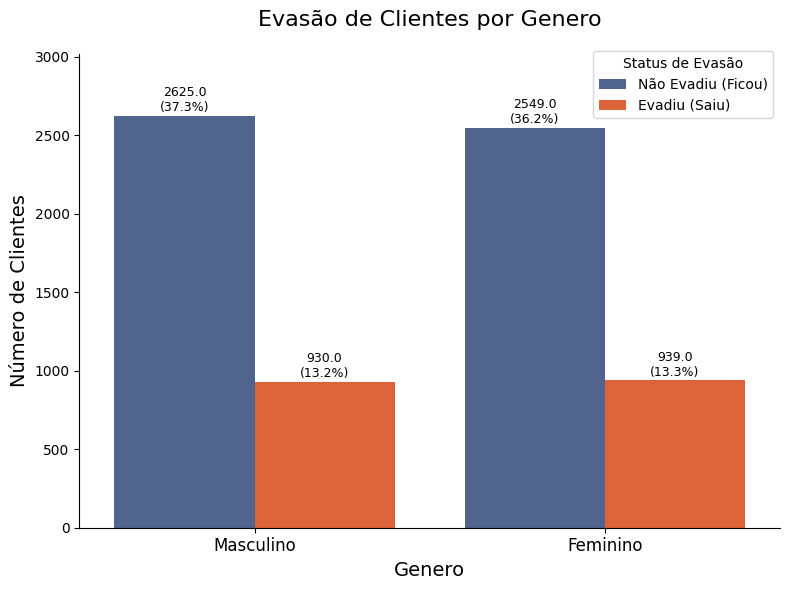

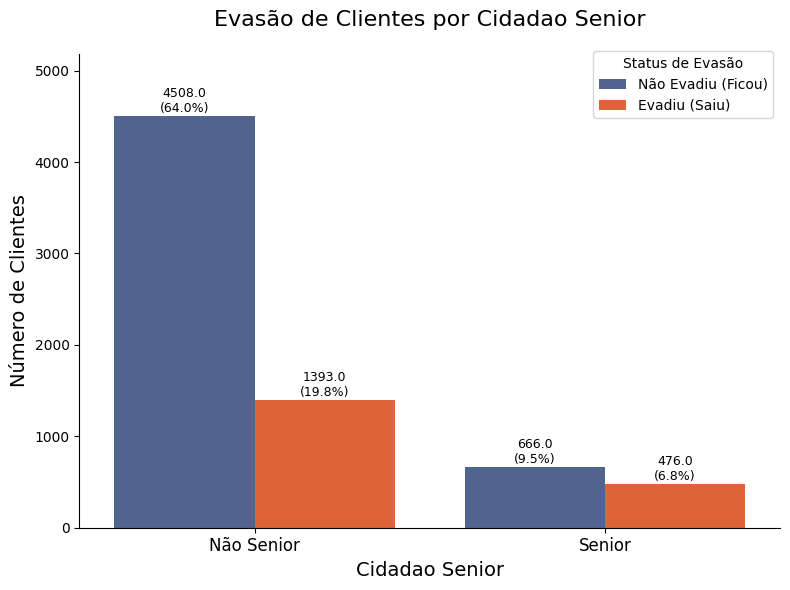

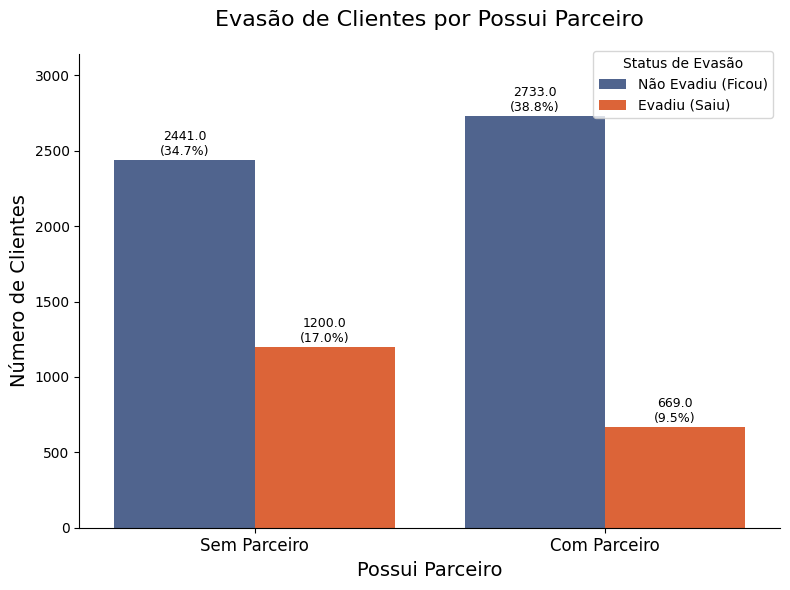

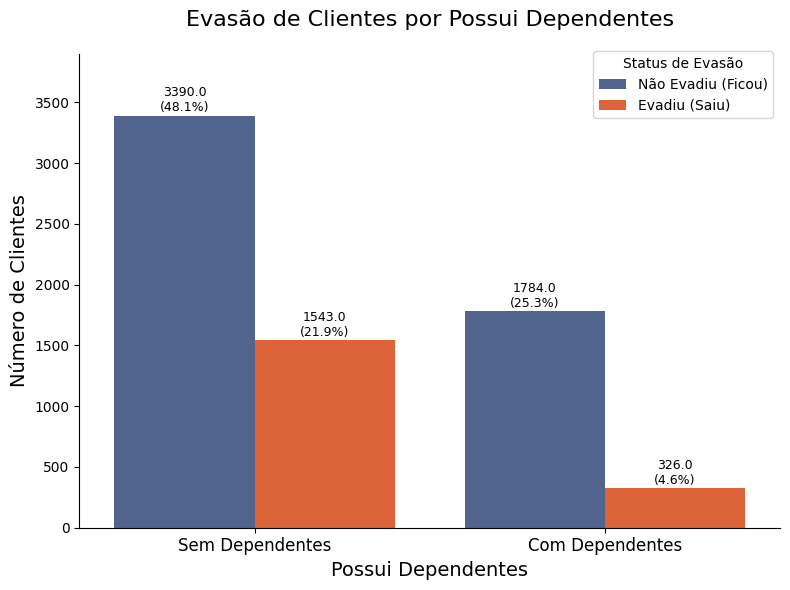

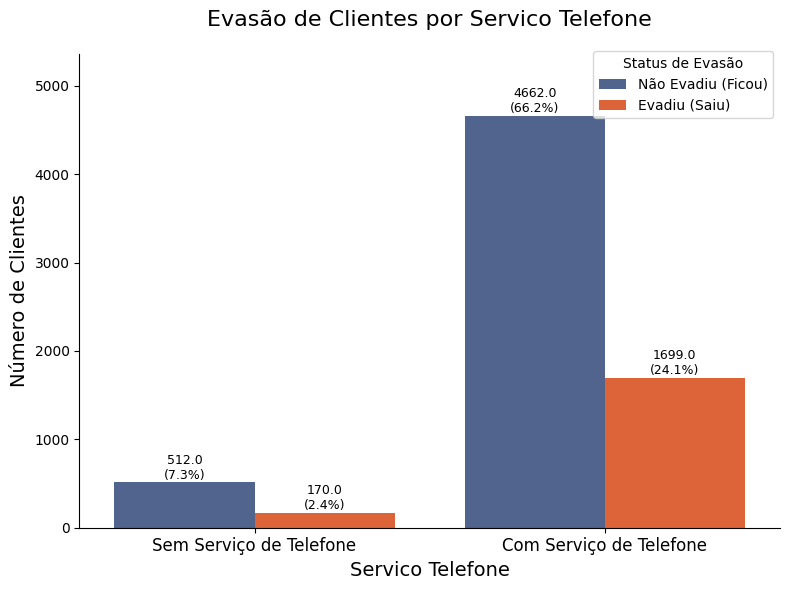

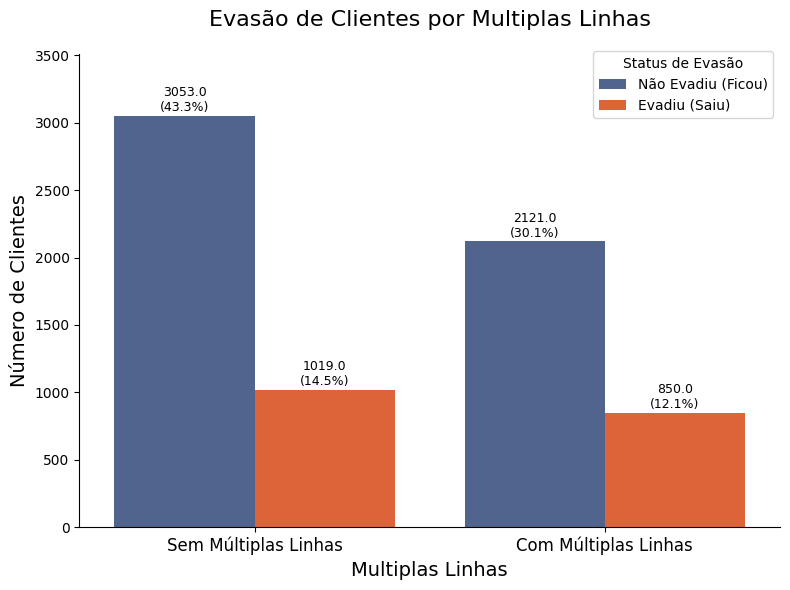

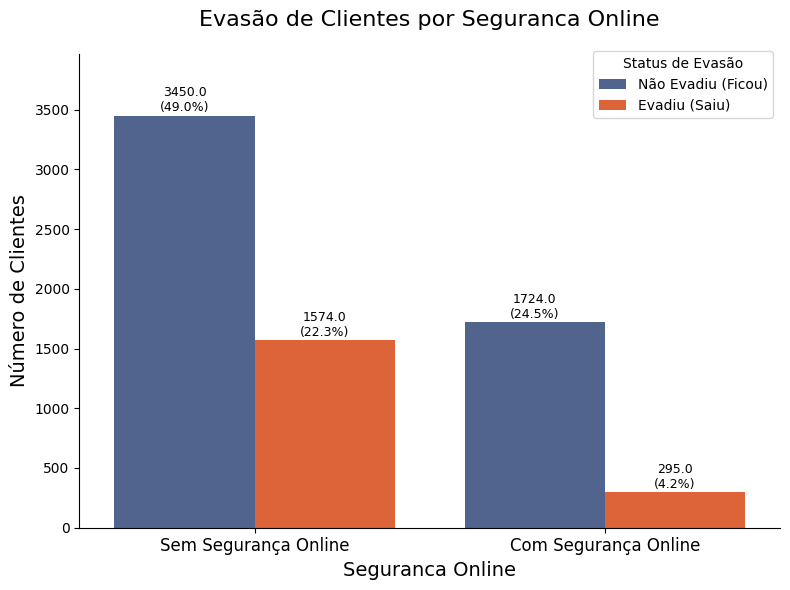

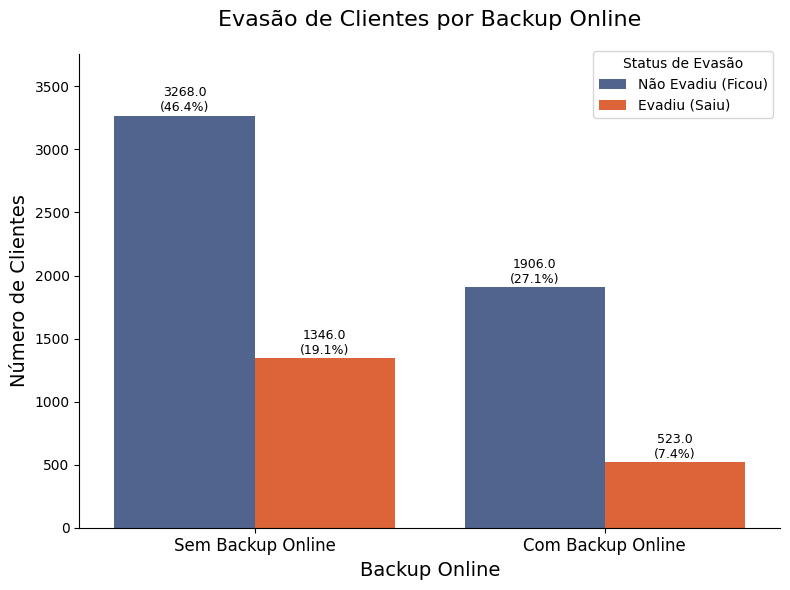

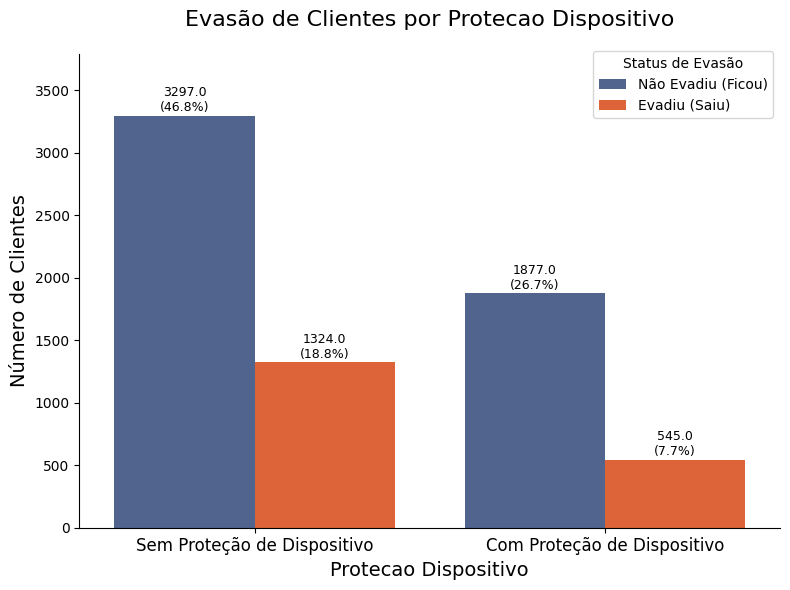

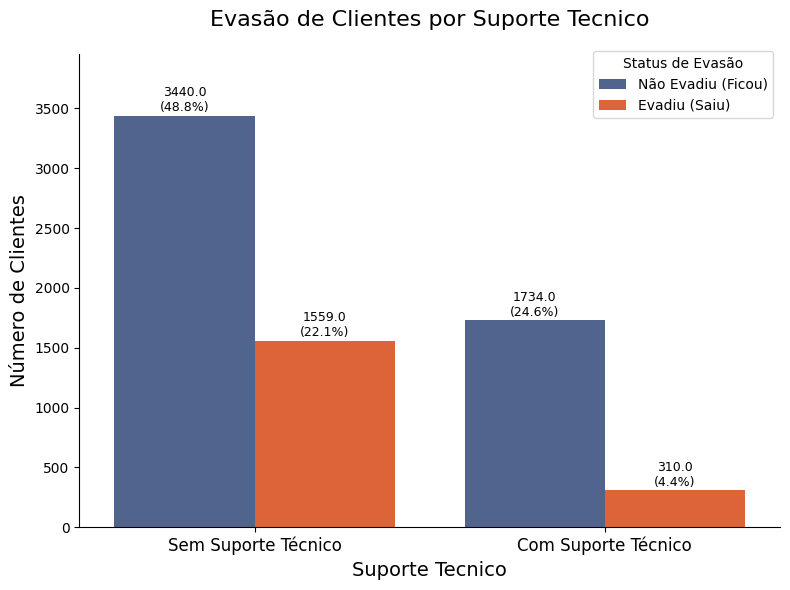

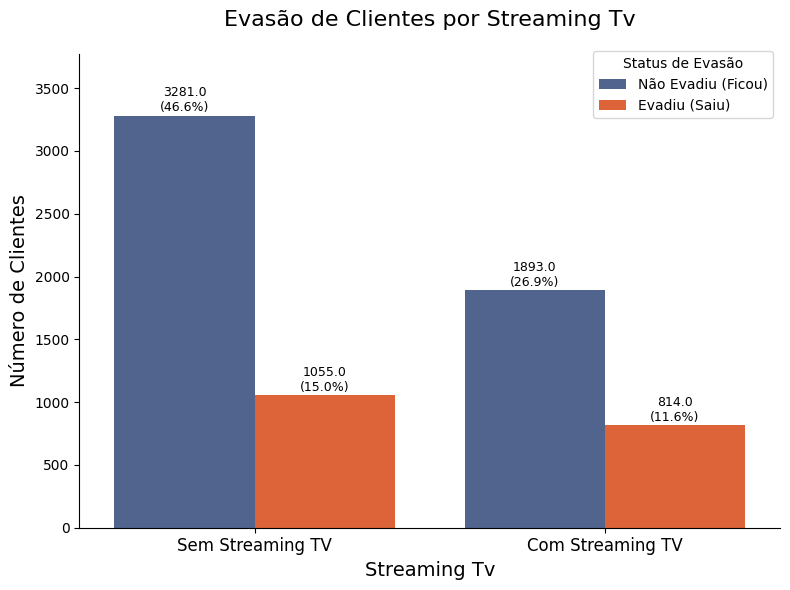

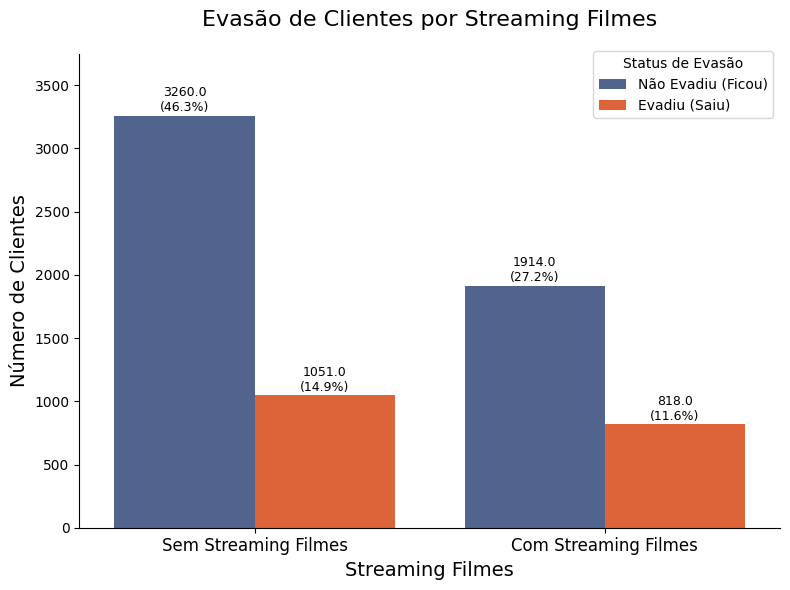

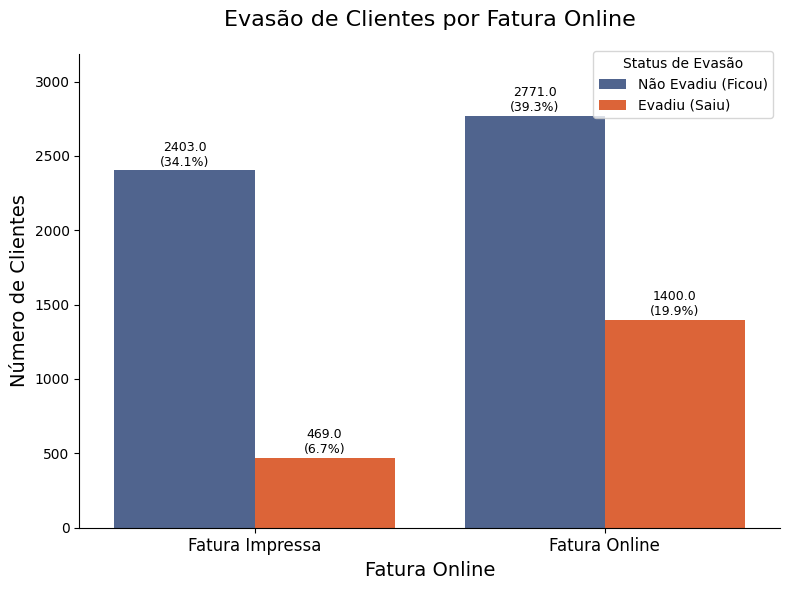

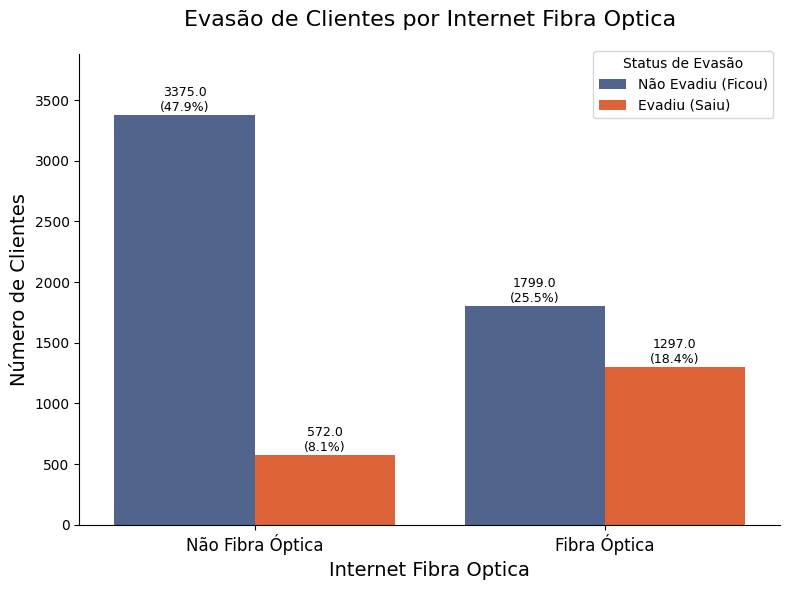

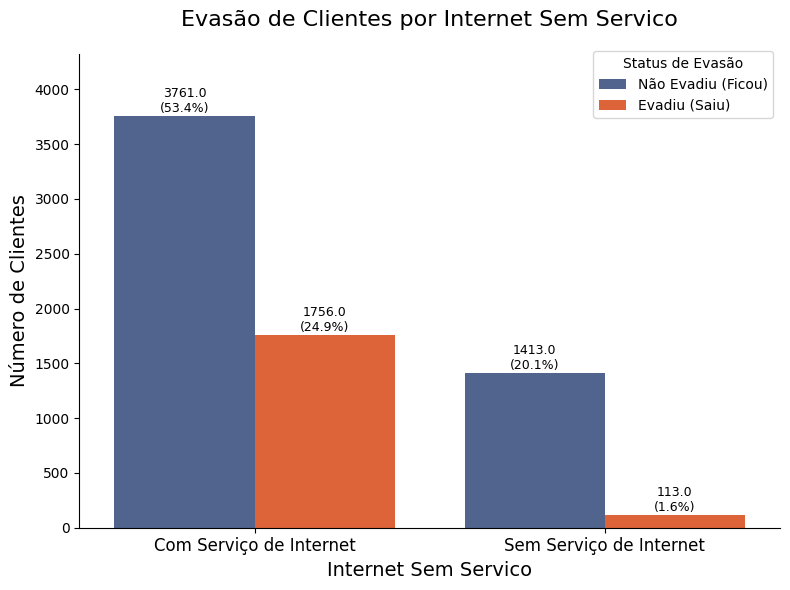

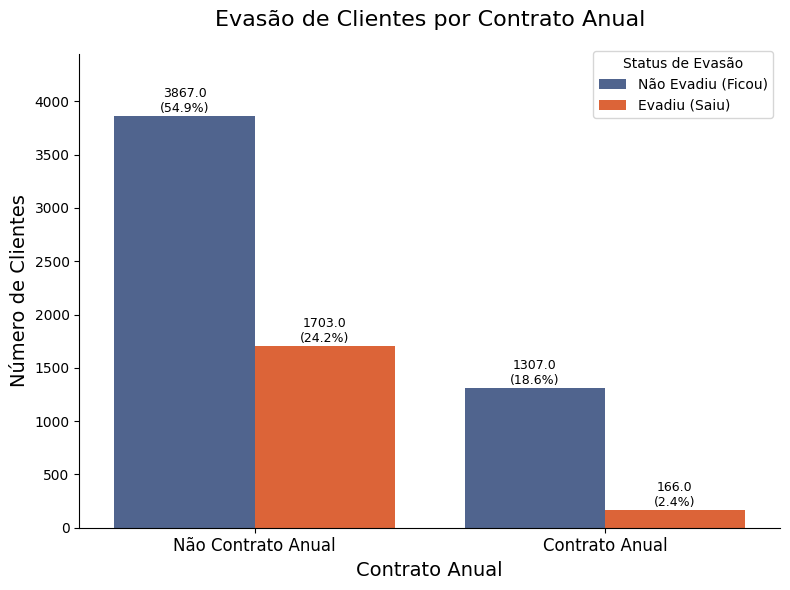

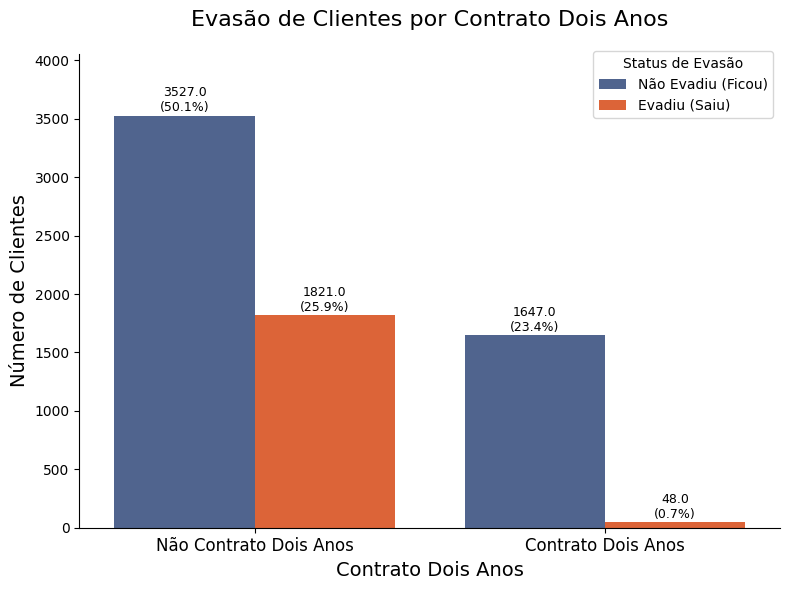

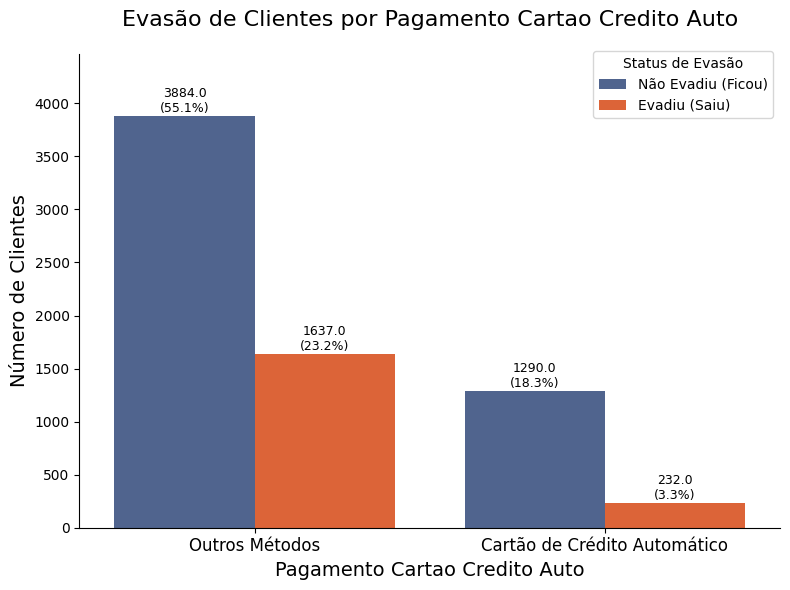

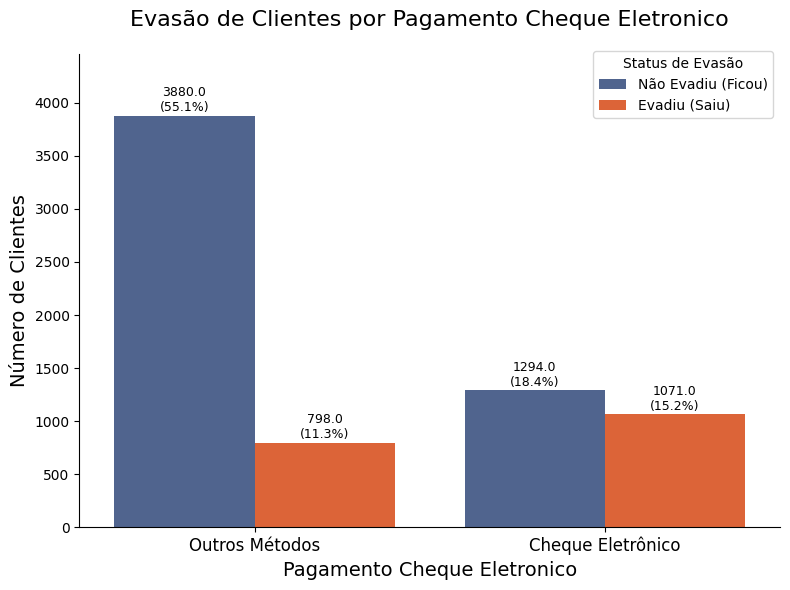

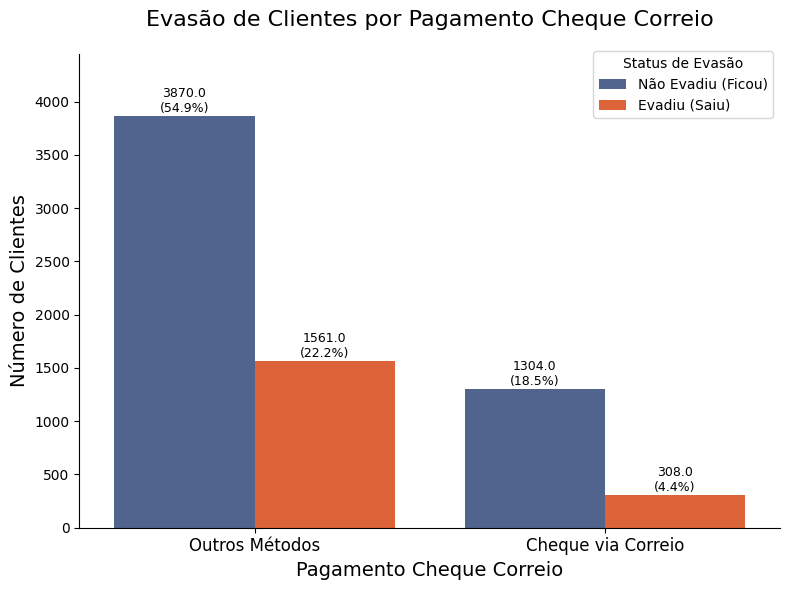

In [14]:
# Célula 4: Análise Exploratória das Variáveis Categóricas/Binárias
print("--- Gerando Gráficos de Evasão por Variáveis Categóricas/Binárias ---")
for col in categorical_cols_to_plot:
    if col in df.columns:
        plot_churn_by_binary_variable(df, col, column_labels.get(col, {0: 'Não', 1: 'Sim'}), churn_palette)
    else:
        print(f"Aviso: Coluna '{col}' não encontrada no DataFrame e foi pulada.")

--- Análise da Distribuição de Variáveis Numéricas por Status de Evasão ---


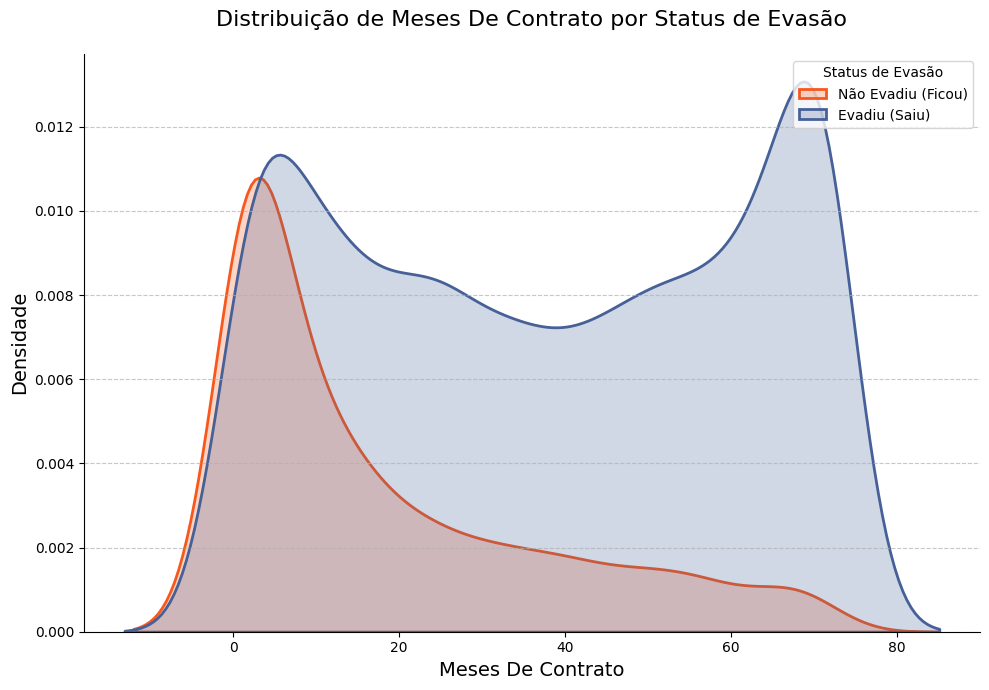

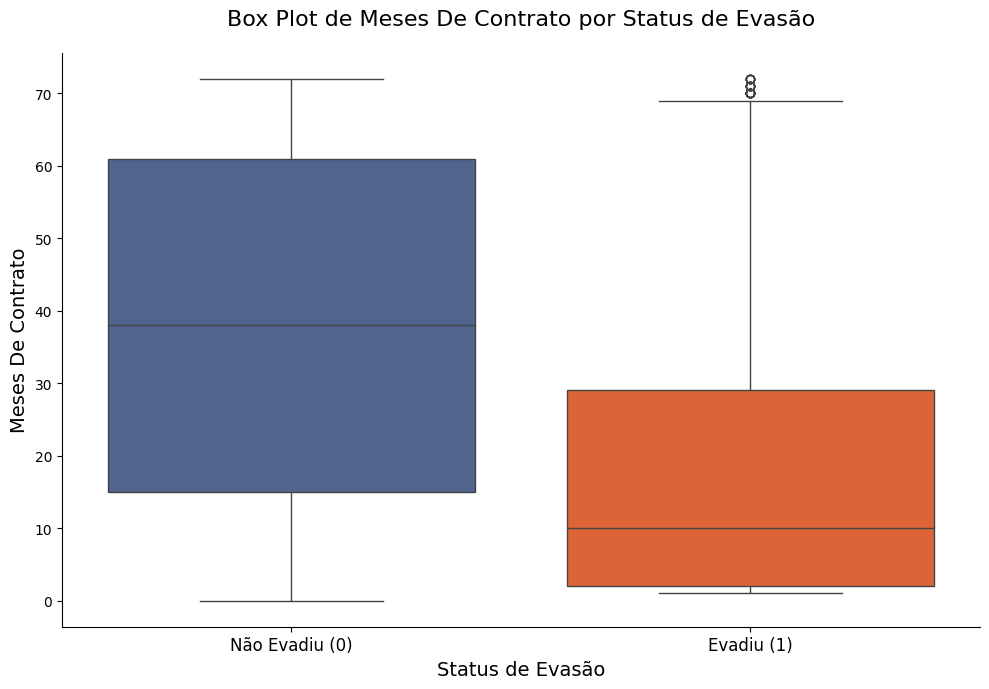

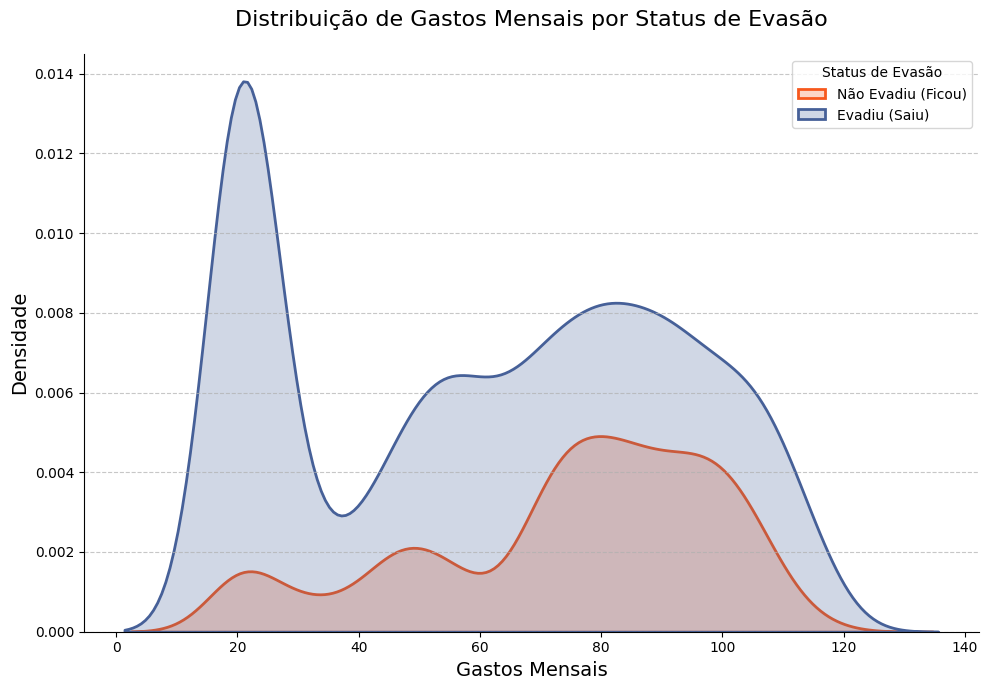

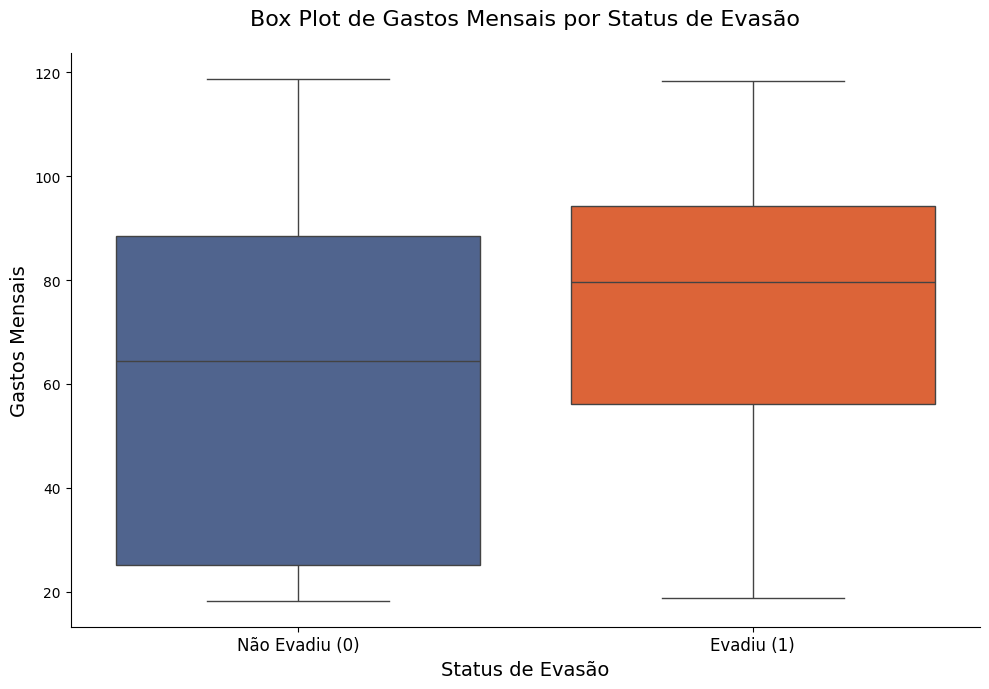

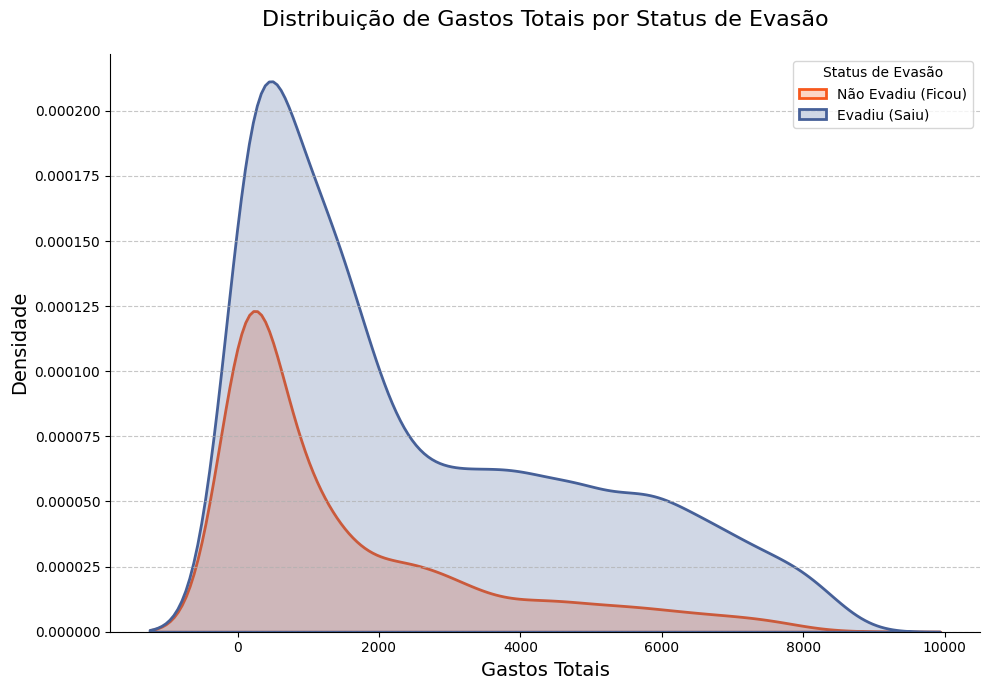

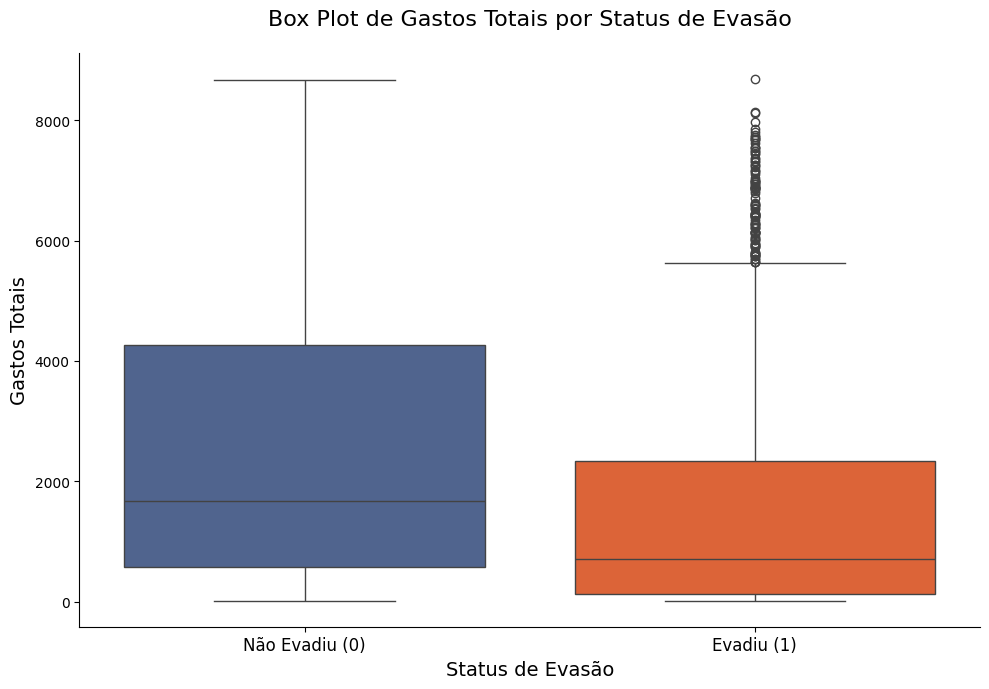


--- Análise de Variáveis Numéricas Concluída! ---


In [15]:
# Célula 5: Análise Exploratória das Variáveis Numéricas
print("--- Análise da Distribuição de Variáveis Numéricas por Status de Evasão ---")
for col in numerical_cols:
    plot_numerical_churn_analysis(df, col, churn_palette)
print("\n--- Análise de Variáveis Numéricas Concluída! ---")


--- Análise da Quantidade de Serviços e Correlação com Evasão ---

Correlação das Variáveis com 'Churn':
churn                            1.000000
internet_fibra_optica            0.308020
pagamento_cheque_eletronico      0.301919
gastos_mensais                   0.193356
gastos_diarios                   0.193356
fatura_online                    0.191825
cidadao_senior                   0.150889
streaming_tv                     0.063228
streaming_filmes                 0.061382
multiplas_linhas                 0.040102
servico_telefone                 0.011942
genero                           0.008612
quantidade_servicos              0.006214
protecao_dispositivo            -0.066160
backup_online                   -0.082255
pagamento_cheque_correio        -0.091683
pagamento_cartao_credito_auto   -0.134302
possui_parceiro                 -0.150448
possui_dependentes              -0.164221
suporte_tecnico                 -0.164674
seguranca_online                -0.171226
contrato_anu

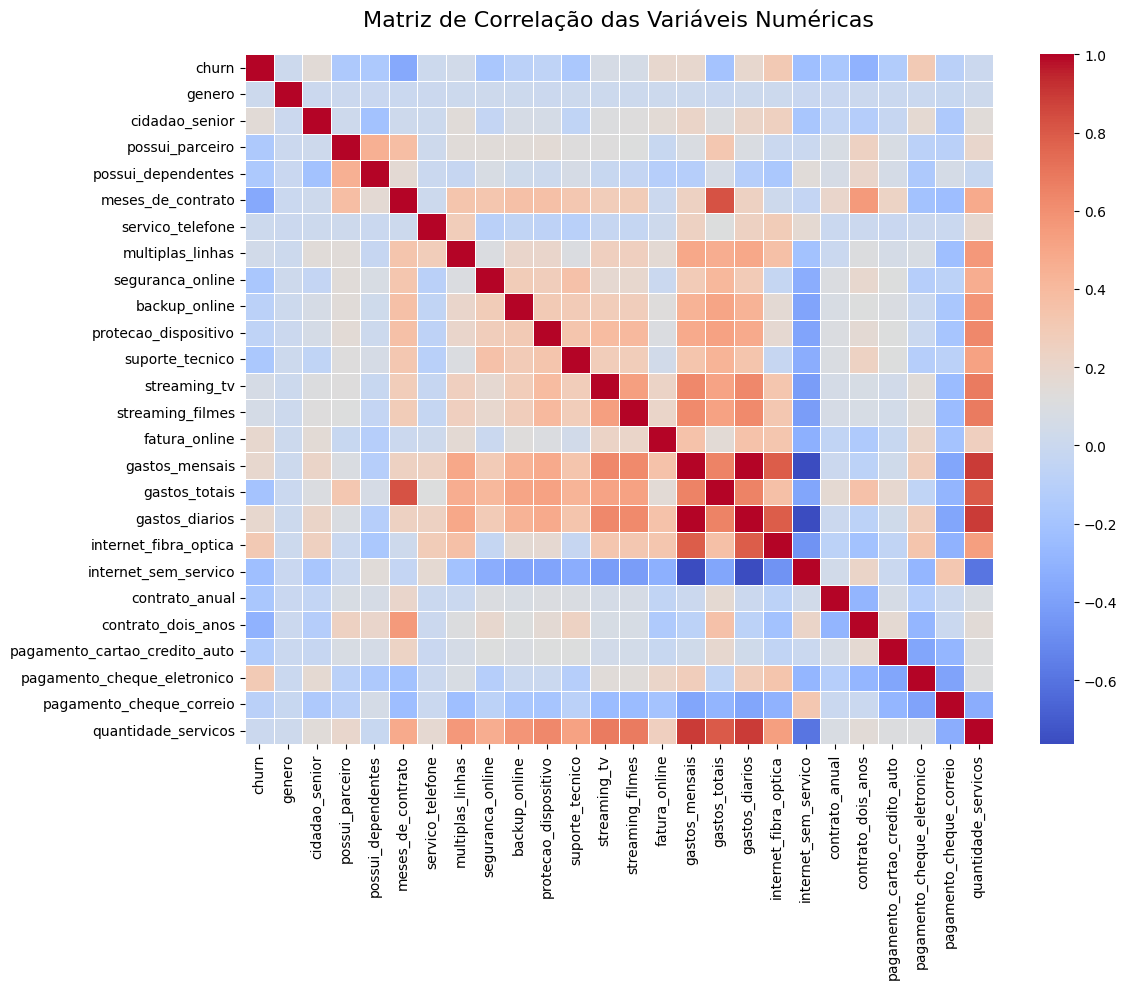


--- Gerando Gráficos de Evasão por Quantidade de Serviços ---


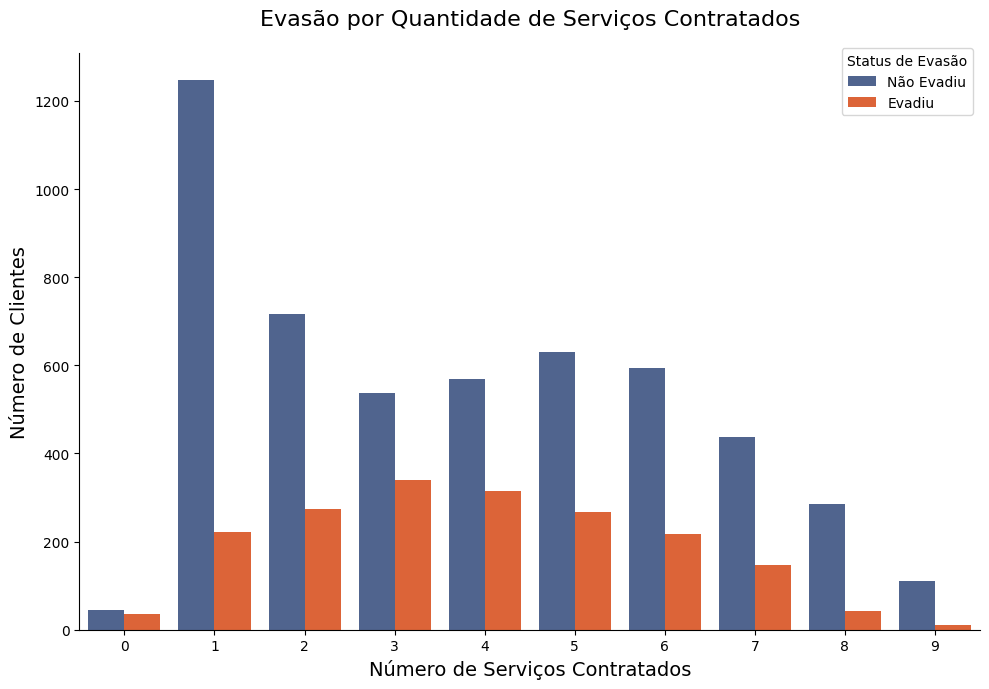

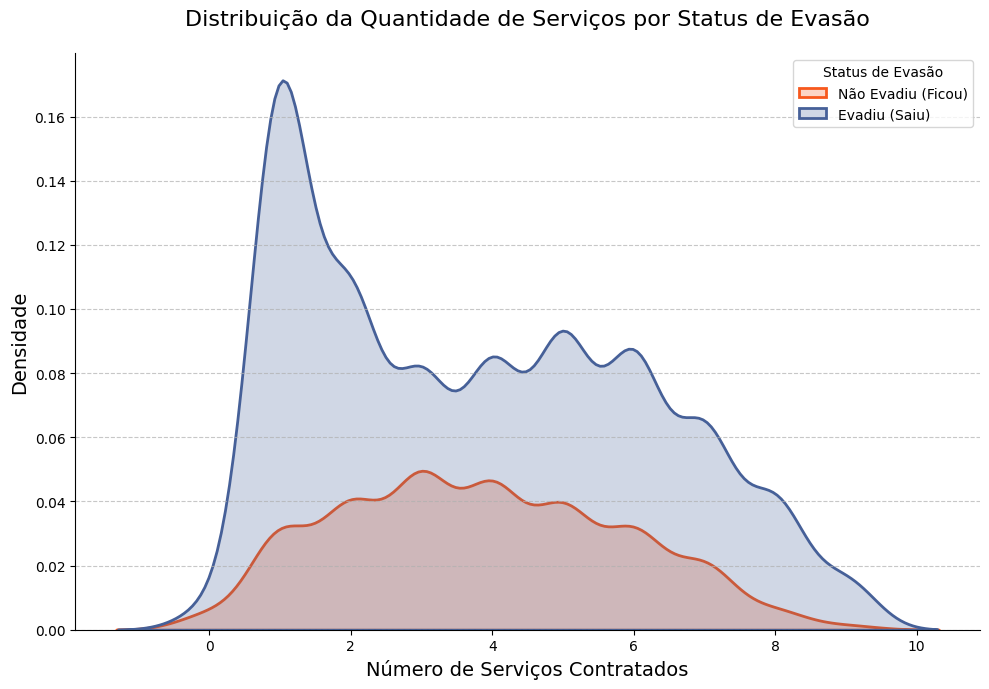

In [16]:
# Célula 6: Análise de Correlação e Criação de Nova Variável
print("\n--- Análise da Quantidade de Serviços e Correlação com Evasão ---")

# 1. Crie a coluna 'quantidade_servicos'
service_cols = [
    'servico_telefone', 'multiplas_linhas', 'seguranca_online',
    'backup_online', 'protecao_dispositivo', 'suporte_tecnico',
    'streaming_tv', 'streaming_filmes', 'internet_fibra_optica'
]
existing_service_cols = [col for col in service_cols if col in df.columns]
df['quantidade_servicos'] = df[existing_service_cols].sum(axis=1)

# 2. Calculando a matriz de correlação
correlation_matrix = df.corr(numeric_only=True)

# 3. Exibindo as correlações mais fortes com 'churn'
print("\nCorrelação das Variáveis com 'Churn':")
print(correlation_matrix['churn'].sort_values(ascending=False))

# 4. Gerando o Heatmap da Matriz de Correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16, pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Geração de gráficos para a nova variável 'quantidade_servicos'
print("\n--- Gerando Gráficos de Evasão por Quantidade de Serviços ---")
plt.figure(figsize=(10, 7))
sns.countplot(x='quantidade_servicos', hue='churn', data=df, palette=churn_palette)
plt.title('Evasão por Quantidade de Serviços Contratados', fontsize=16, pad=20)
plt.xlabel('Número de Serviços Contratados', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
plt.legend(title='Status de Evasão', labels=['Não Evadiu', 'Evadiu'], fontsize=10, loc='upper right', bbox_to_anchor=(1, 1.02))
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
sns.kdeplot(data=df, x='quantidade_servicos', hue='churn', fill=True, palette=churn_palette, linewidth=2)
plt.title('Distribuição da Quantidade de Serviços por Status de Evasão', fontsize=16, pad=20)
plt.xlabel('Número de Serviços Contratados', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.legend(title='Status de Evasão', labels=['Não Evadiu (Ficou)', 'Evadiu (Saiu)'],
               fontsize=10, loc='upper right', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

#📄Relatorio Final

# **Relatório: Telecom X - Análise de Evasão de Clientes (Churn)**
# **1. Introdução**  


A Telecom X, é uma provedora de serviços de telecomunicações, enfrenta um desafio crescente: o alto índice de cancelamento de clientes, conhecido como "churn". Compreender os motivos por trás dessa evasão é fundamental para a saúde financeira e o crescimento da empresa. Este relatório apresenta a análise exploratória de dados (EDA) realizada para identificar padrões, tendências e os principais fatores que influenciam a decisão dos clientes de cancelar seus serviços. Os insights aqui gerados servirão como base para a equipe de Data Science desenvolver modelos preditivos mais robustos e criar estratégias de retenção eficazes.


---



# **2. Limpeza e Tratamento de Dados**  
As etapas cruciais de Extração, Transformação e Carga (ETL) foram realizadas para preparar o conjunto de dados para esta análise. Isso incluiu:

*   **Extração:** Os dados foram importados de uma API.

*   **Tratamento de Valores Ausentes:** Identificação e manuseio de valores `NaN` ou vazios, especialmente na coluna de gastos totais, garantindo que todos os dados numéricos estivessem aptos para cálculos.

*   **Normalização e Conversão de Tipos:**Garantia de que todas as colunas estivessem no formato de dados correto (numérico, categórico, etc.), com padronização e normalização aplicadas conforme necessário para otimizar a análise.

*   **Criação de Variáveis Derivadas:**Novas features, como `quantidade_servicos`, foram criadas para enriquecer a análise, combinando informações de múltiplas colunas binárias de serviço.

Este processo garantiu a qualidade e a integridade dos dados, fundamentais para a geração de insights confiáveis.

---



# **3. Análise Exploratória de Dados (EDA)**
A Análise Exploratória de Dados revelou padrões significativos na relação entre as características dos clientes e sua propensão à evasão.

## **3.1. Evasão por Variáveis Categóricas/Binárias**
Para cada variável categórica binária, foram utilizados gráficos de barras (countplots) para visualizar a proporção de clientes que evadiram vs. os que permaneceram em cada categoria. Isso permite uma compreensão clara do impacto de características como gênero, posse de parceiros, tipo de internet, etc., na taxa de churn.

## **Gráficos Explicativos:**

*  **Evasão por Gênero:** Revela se há diferenças notáveis na taxa de evasão entre clientes masculinos e femininos.

*  **Evasão por Cidadão Sênior:** Mostra se a idade avançada (ser um cidadão sênior) está associada a uma maior ou menor propensão a cancelar.

*  **Evasão por Possui Parceiro e Possui Dependentes:** Essenciais para entender como a estrutura familiar (e, por inferência, a necessidade e dependência do serviço) influencia a lealdade. Clientes com laços familiares podem ter menor propensão ao churn.

*  **Evasão por Serviço de Telefone e Fibra Óptica:** Analisam o impacto da posse desses serviços específicos na evasão.

*  **Evasão por Fatura Online:** Indica se a preferência por faturamento digital afeta a taxa de churn.

*  **Evasão por Contrato Anual e Contrato de Dois Anos:** Cruciais para demonstrar o impacto da duração do compromisso no churn. Contratos mais longos geralmente implicam em menor evasão.

---


--- Gerando Gráficos para a Seção 3.1 ---


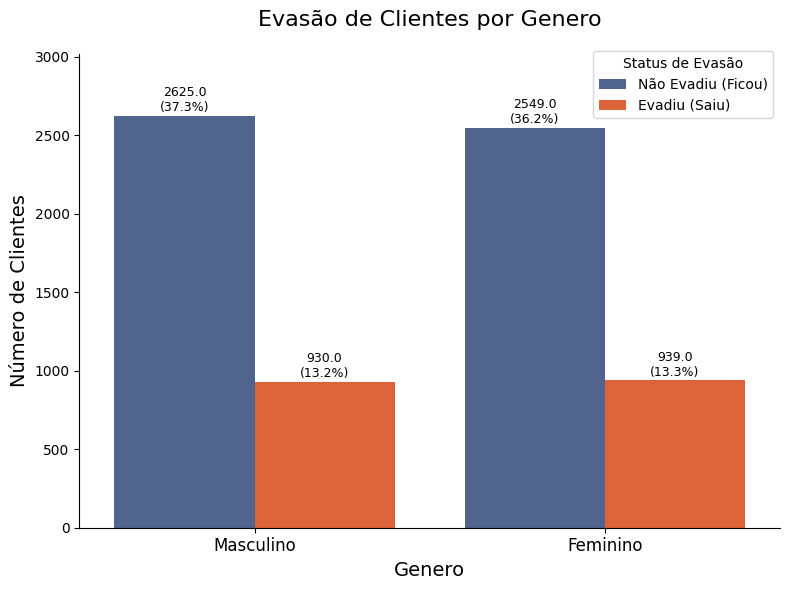

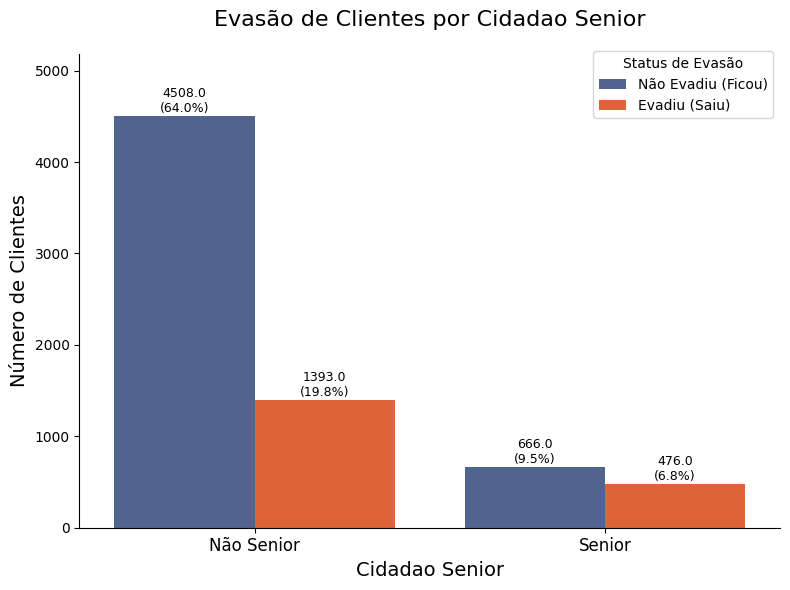

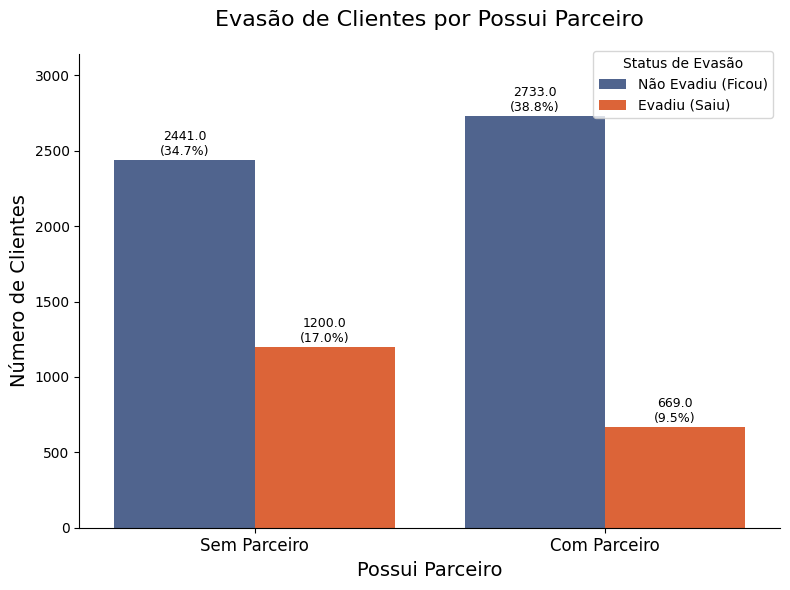

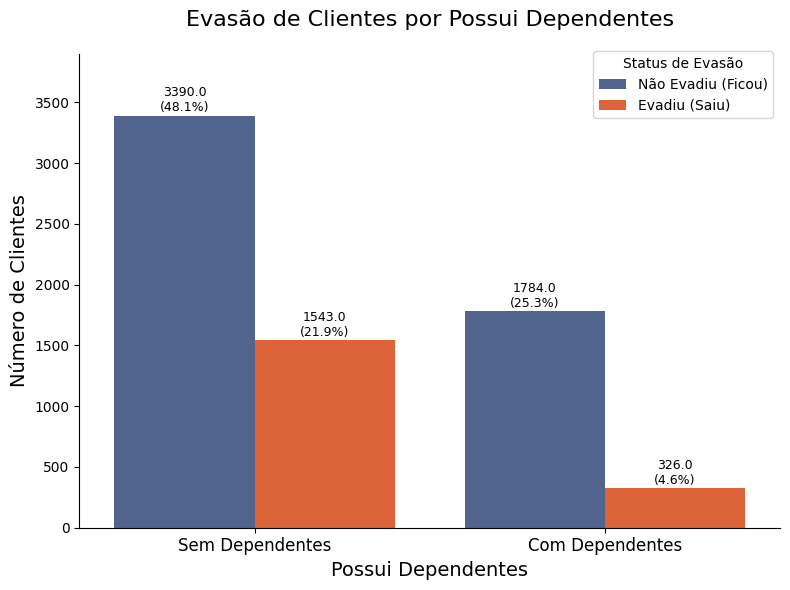

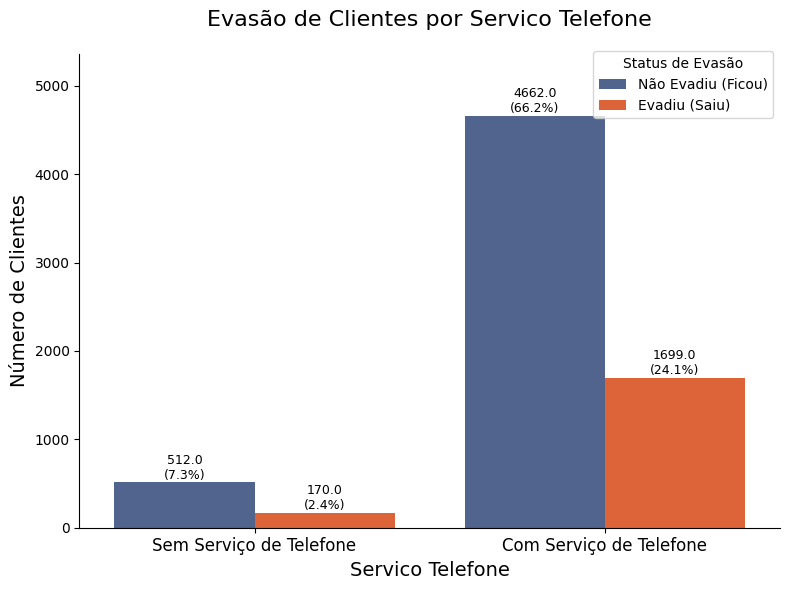

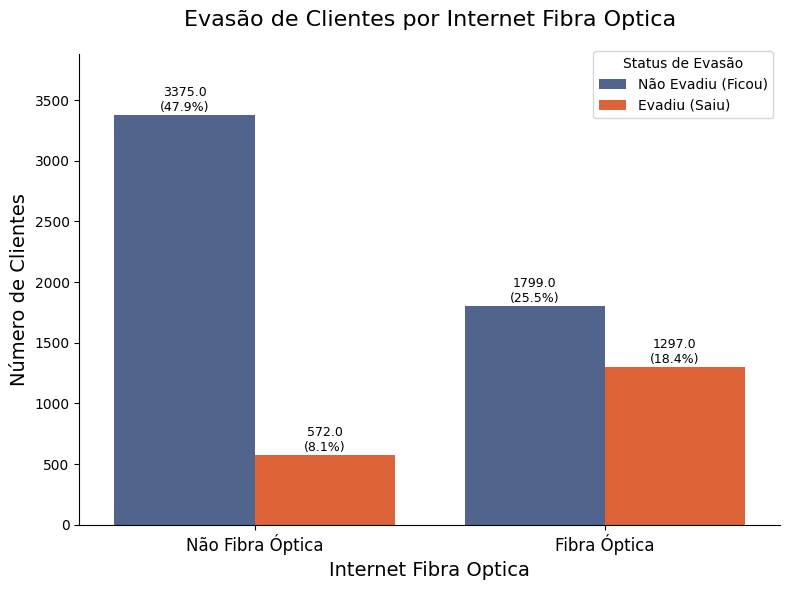

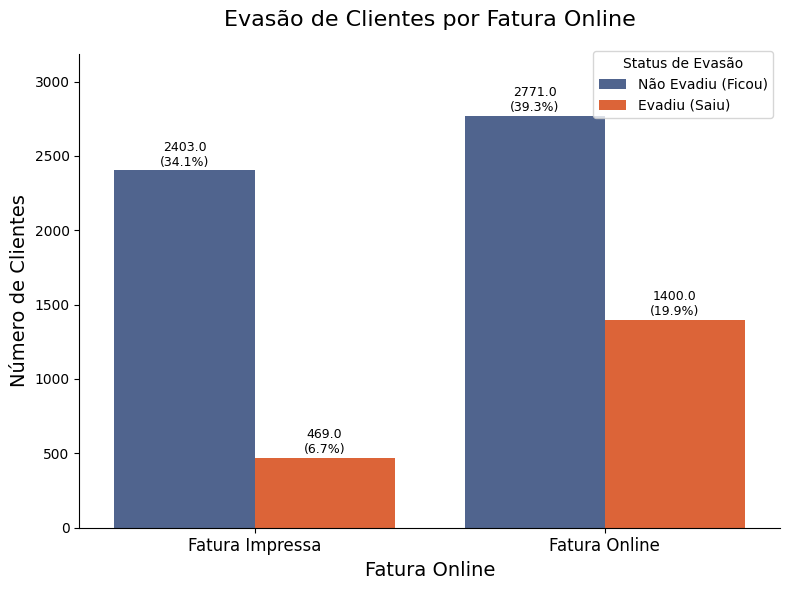

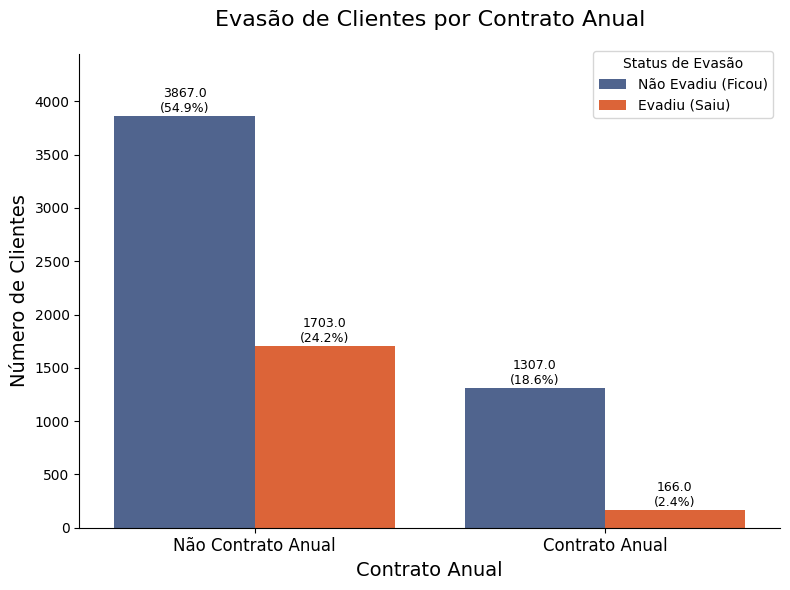

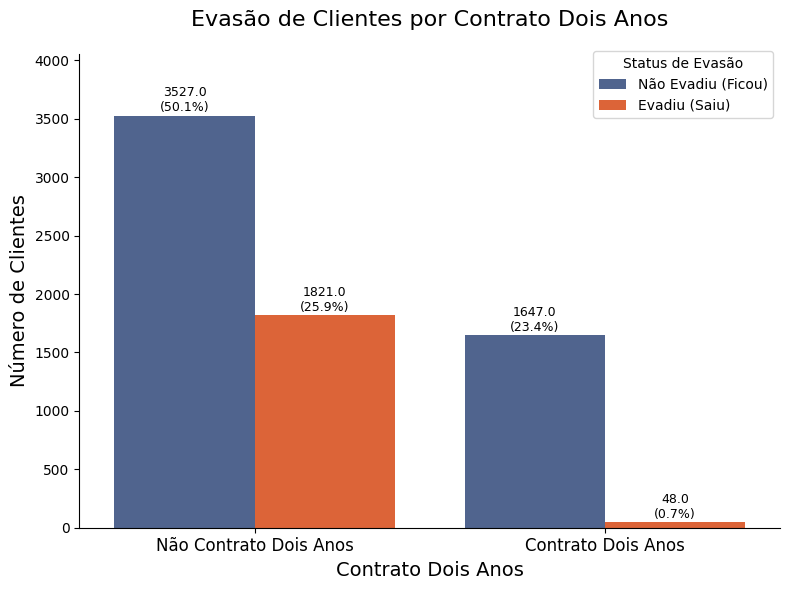


--- Gráficos para a Seção 3.1 concluídos. ---


In [17]:
# Gráficos da Seção 3.1
print("--- Gerando Gráficos para a Seção 3.1 ---")

report_categorical_cols = [
    'genero',
    'cidadao_senior',
    'possui_parceiro',
    'possui_dependentes',
    'servico_telefone',
    'internet_fibra_optica',
    'fatura_online',
    'contrato_anual',
    'contrato_dois_anos'
]

for col in report_categorical_cols:
    if col in df.columns:
        plot_churn_by_binary_variable(df, col, column_labels.get(col, {0: 'Não', 1: 'Sim'}), churn_palette)
    else:
        print(f"Aviso: Coluna '{col}' não encontrada no DataFrame e foi pulada.")

print("\n--- Gráficos para a Seção 3.1 concluídos. ---")

## **3.2. Evasão por Variáveis Numéricas**
Para as variáveis numéricas mais impactantes, foram utilizados gráficos de densidade (KDE plots) e box plots. Essas visualizações permitem analisar a distribuição e a centralidade dos dados de clientes que evadiram versus os que não evadiram.

**Gráficos Explicativos:**

*  **Distribuição e Box Plot de Meses de Contrato por Status de Evasão: (Gráficos 1 e 2)**

 *  **Insight Principal:** Há uma correlação inversa muito forte: clientes que evadem tendem a ter um tempo de contrato significativamente menor, com um pico de evasão nos primeiros meses de serviço.

*  **Distribuição e Box Plot de Gastos Mensais por Status de Evasão: (Gráficos 3 e 4)**

 *  **Insight Principal:** Clientes que evadem tendem a ter `gastos_mensais` ligeiramente maiores, sugerindo que planos mais caros podem estar associados a uma maior propensão ao churn, possivelmente devido à percepção de valor ou sensibilidade ao preço.

*  **Distribuição e Box Plot de Gastos Totais por Status de Evasão: (Gráficos 5 e 6)**

 *  **Insight Principal:** Clientes que evadem possuem `gastos_totais` consideravelmente menores. Isso reforça a ideia de que a evasão ocorre predominantemente no início do ciclo de vida do cliente. Os "outliers" de `gastos_totais` no grupo 'Evadiu' (clientes que cancelaram com gastos totais relativamente altos) indicam casos de churn de clientes mais antigos ou de maior valor, que merecem investigação específica.
 ---

--- Gerando Gráficos para a Seção 3.2 do Relatório ---


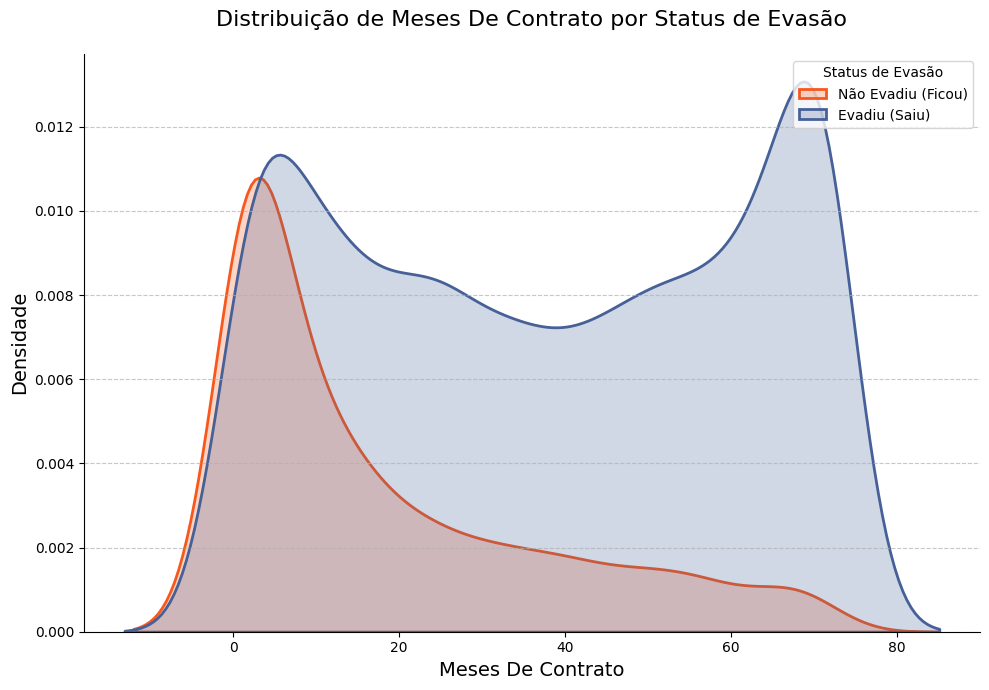

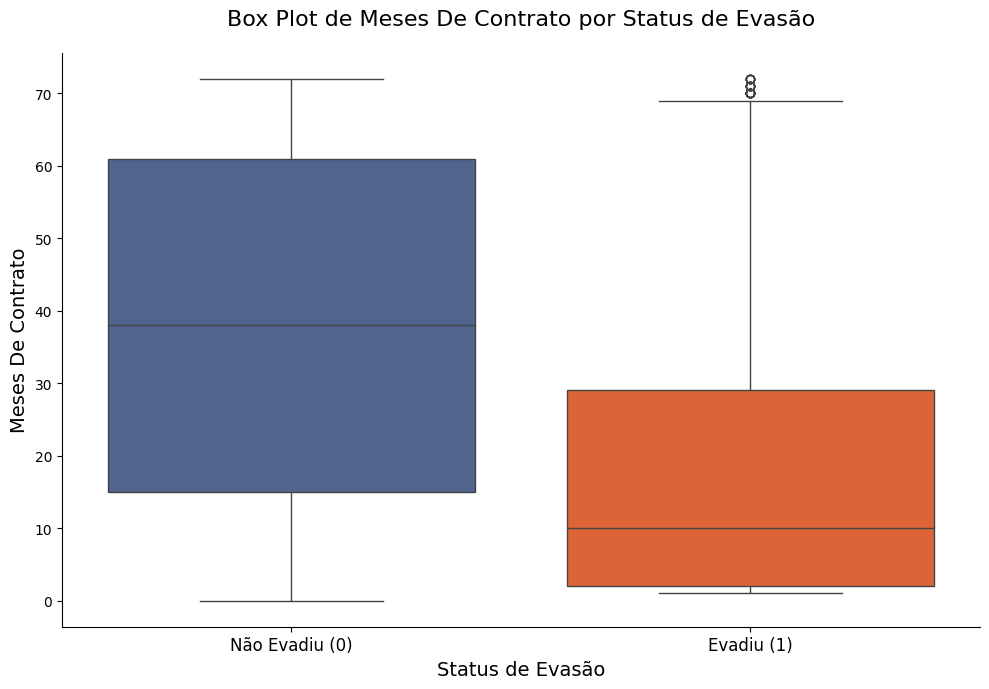

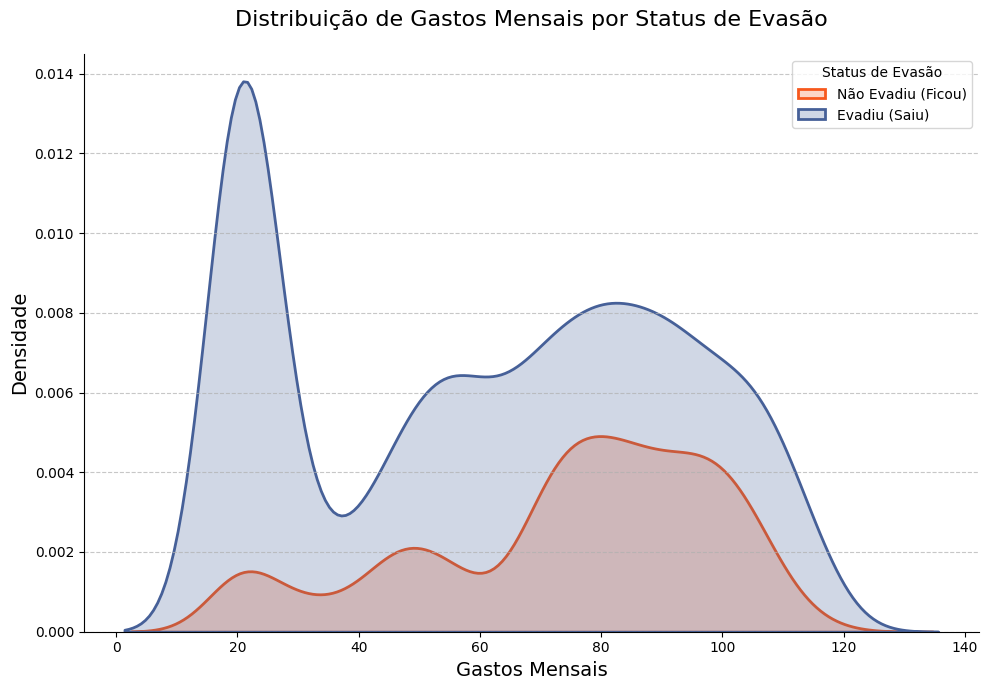

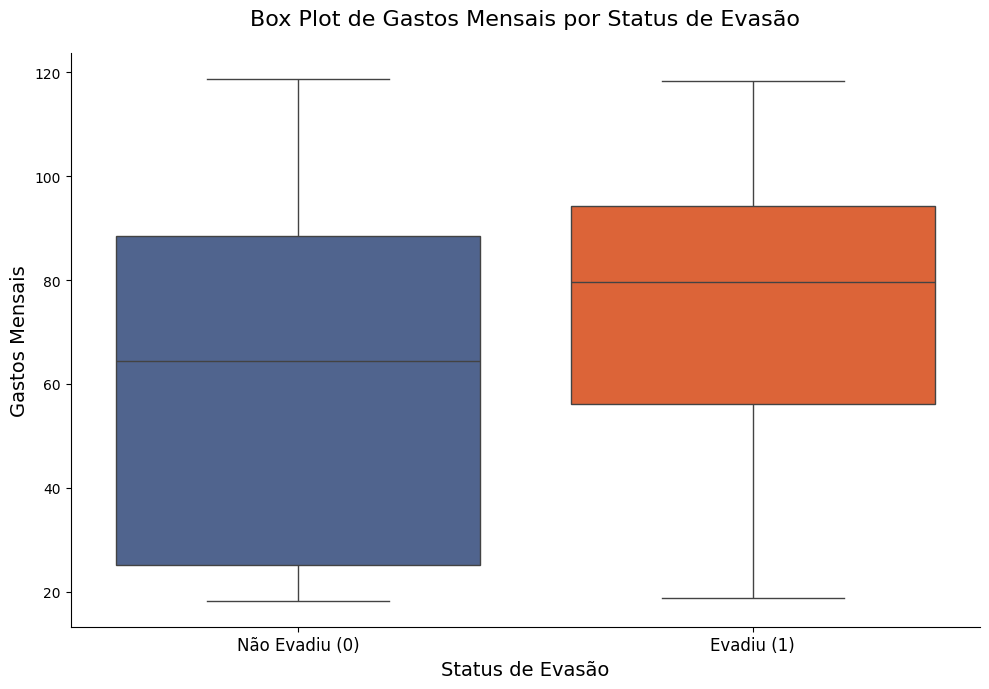

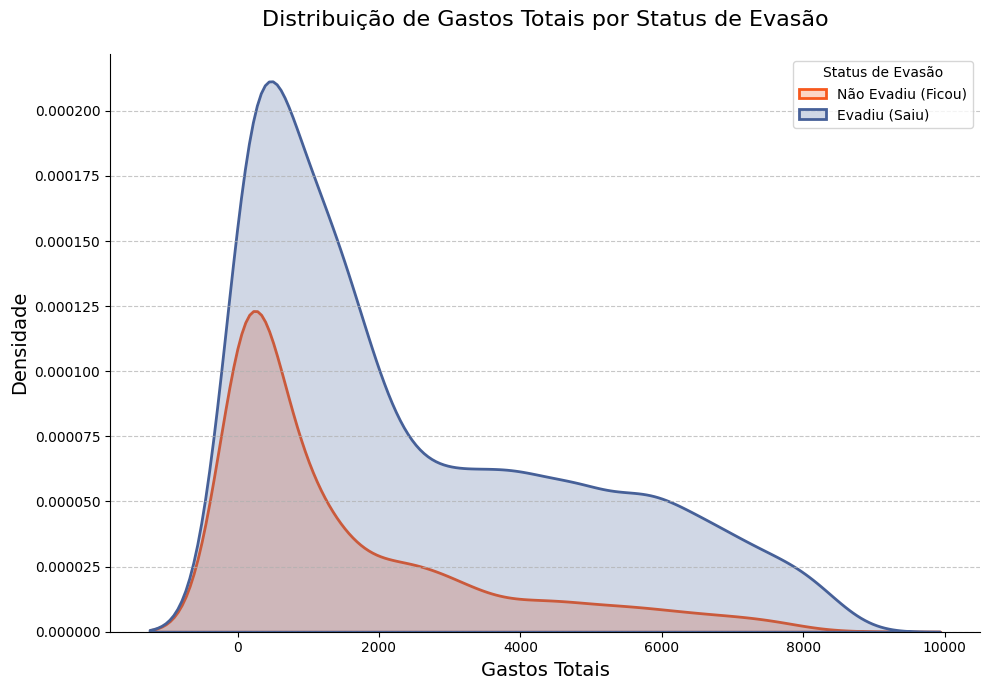

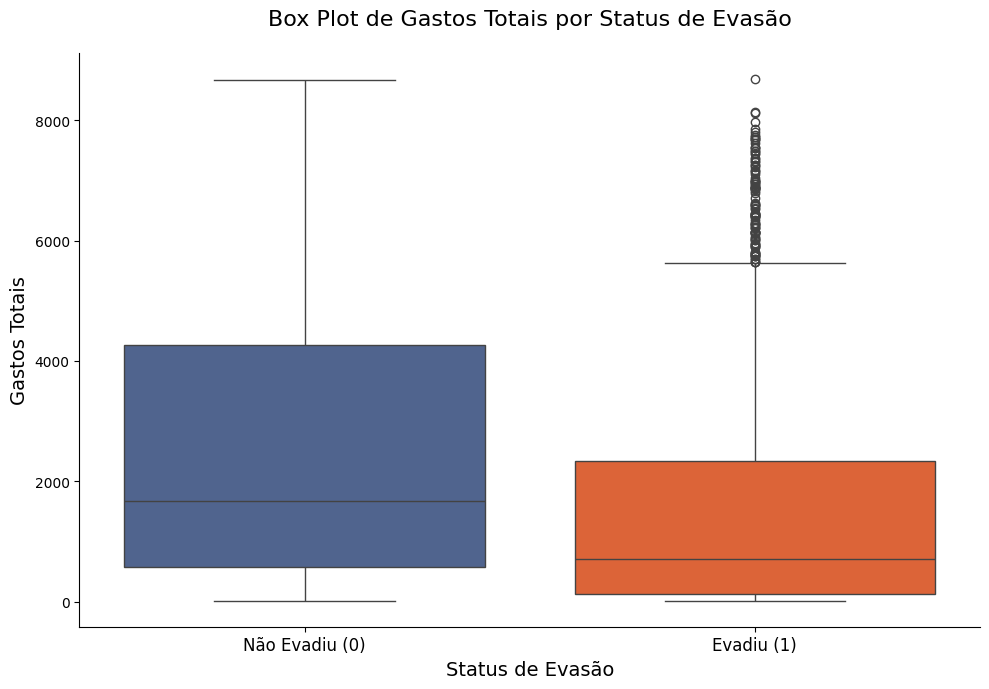


--- Gráficos para a Seção 3.2 concluídos. ---


In [18]:
# Gráficos da Seção 3.2
print("--- Gerando Gráficos para a Seção 3.2 do Relatório ---")

report_numerical_cols = [
    'meses_de_contrato',
    'gastos_mensais',
    'gastos_totais'
]

# Gerar os gráficos de densidade e box plots
for col in report_numerical_cols:
    if col in df.columns:
        plot_numerical_churn_analysis(df, col, churn_palette)
    else:
        print(f"Aviso: Coluna '{col}' não encontrada no DataFrame e foi pulada.")

print("\n--- Gráficos para a Seção 3.2 concluídos. ---")

# **3.3. Análise de Correlação**
A análise de correlação oferece uma visão quantitativa das relações lineares entre todas as variáveis numéricas e o status de evasão (`churn`).

**Gráficos Explicativos:**

*  **Matriz de Correlação (Heatmap):** Oferece um mapa visual de todas as correlações entre as variáveis numéricas. A linha/coluna 'churn' é de particular interesse, mostrando as variáveis com as relações mais fortes (positivas ou negativas) com a evasão.

*  **Evasão por Quantidade de Serviços Contratados (Countplot e KDE Plot):** Analisa se o número de serviços que um cliente contrata tem influência na probabilidade de churn. Isso pode indicar se um pacote de serviços muito básico ou, inversamente, um pacote muito complexo/caro, contribui para a evasão.


---

--- Gerando Gráficos para a Seção 3.3 ---

Correlação das Variáveis com 'Churn':
churn                            1.000000
internet_fibra_optica            0.308020
pagamento_cheque_eletronico      0.301919
gastos_mensais                   0.193356
gastos_diarios                   0.193356
fatura_online                    0.191825
cidadao_senior                   0.150889
streaming_tv                     0.063228
streaming_filmes                 0.061382
multiplas_linhas                 0.040102
servico_telefone                 0.011942
genero                           0.008612
quantidade_servicos              0.006214
protecao_dispositivo            -0.066160
backup_online                   -0.082255
pagamento_cheque_correio        -0.091683
pagamento_cartao_credito_auto   -0.134302
possui_parceiro                 -0.150448
possui_dependentes              -0.164221
suporte_tecnico                 -0.164674
seguranca_online                -0.171226
contrato_anual                  -0.17

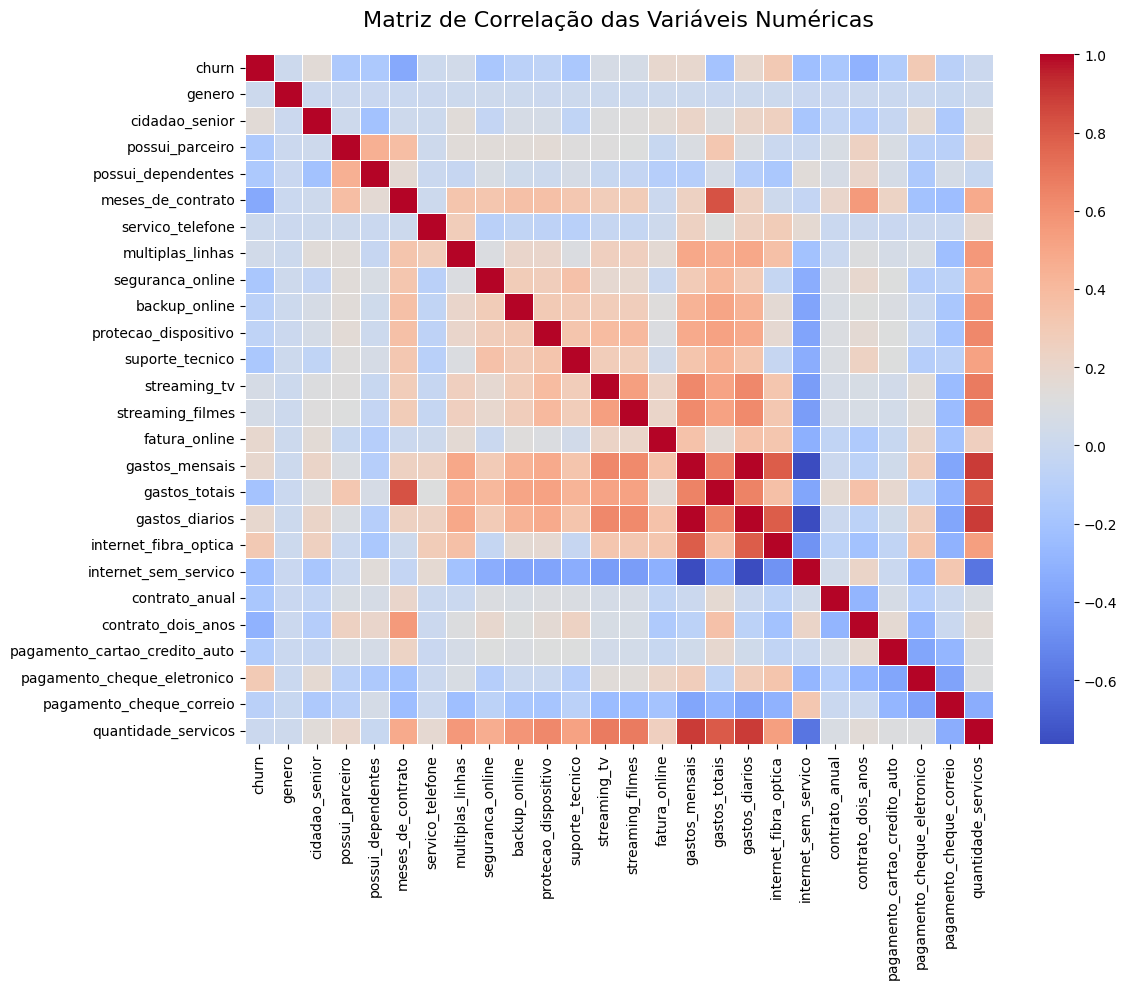


--- Gerando Gráficos de Evasão por Quantidade de Serviços ---


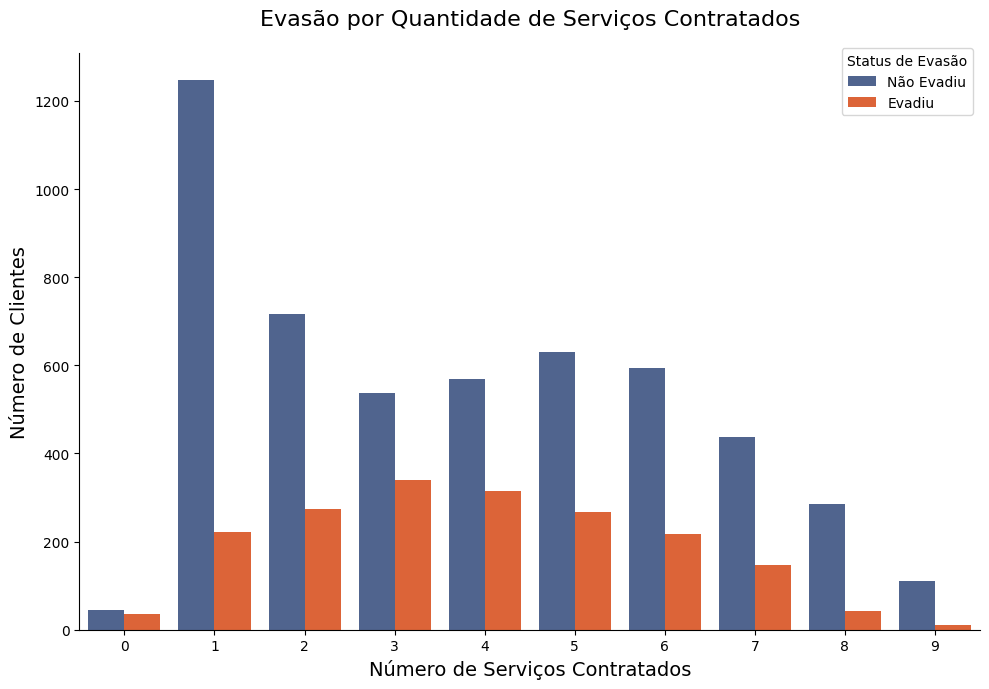

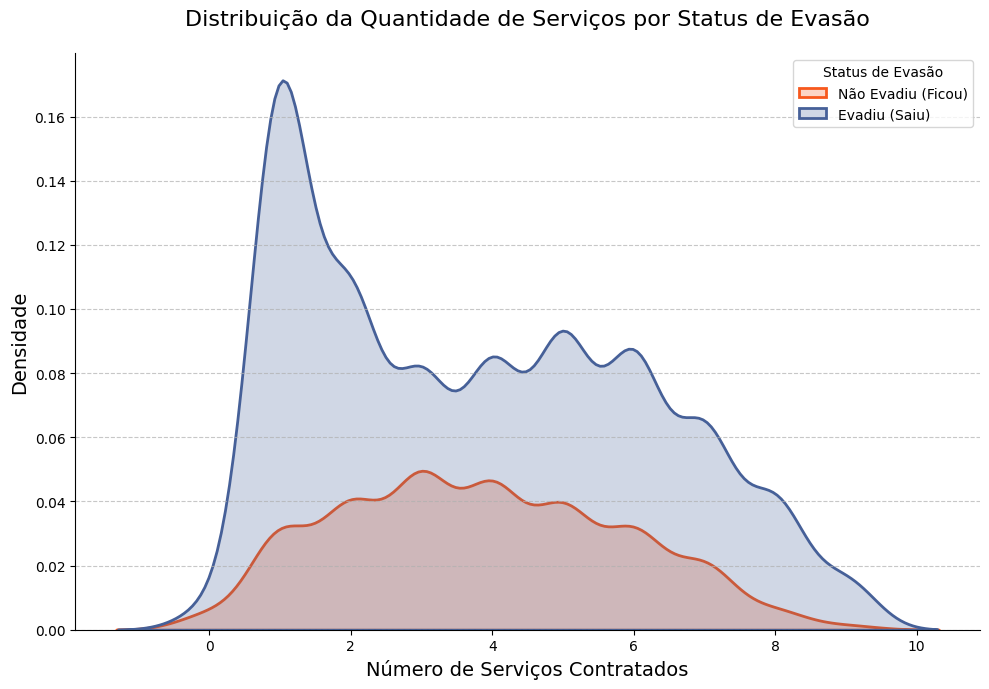


--- Gráficos para a Seção 3.3 concluídos. ---


In [19]:
# Gerar os gráficos da Seção 3.3
print("--- Gerando Gráficos para a Seção 3.3 ---")

# 1. Criação da coluna 'quantidade_servicos'
service_cols = [
    'servico_telefone', 'multiplas_linhas', 'seguranca_online',
    'backup_online', 'protecao_dispositivo', 'suporte_tecnico',
    'streaming_tv', 'streaming_filmes', 'internet_fibra_optica'
]
existing_service_cols = [col for col in service_cols if col in df.columns]
if not 'quantidade_servicos' in df.columns:
    df['quantidade_servicos'] = df[existing_service_cols].sum(axis=1)

# 2. Calculando a matriz de correlação e exibindo os resultados
correlation_matrix = df.corr(numeric_only=True)
print("\nCorrelação das Variáveis com 'Churn':")
print(correlation_matrix['churn'].sort_values(ascending=False))

# 3. Gerando o Heatmap da Matriz de Correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16, pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Geração de gráficos para a nova variável 'quantidade_servicos'
print("\n--- Gerando Gráficos de Evasão por Quantidade de Serviços ---")

plt.figure(figsize=(10, 7))
sns.countplot(x='quantidade_servicos', hue='churn', data=df, palette=churn_palette)
plt.title('Evasão por Quantidade de Serviços Contratados', fontsize=16, pad=20)
plt.xlabel('Número de Serviços Contratados', fontsize=14)
plt.ylabel('Número de Clientes', fontsize=14)
plt.legend(title='Status de Evasão', labels=['Não Evadiu', 'Evadiu'], fontsize=10, loc='upper right', bbox_to_anchor=(1, 1.02))
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
sns.kdeplot(data=df, x='quantidade_servicos', hue='churn', fill=True, palette=churn_palette, linewidth=2)
plt.title('Distribuição da Quantidade de Serviços por Status de Evasão', fontsize=16, pad=20)
plt.xlabel('Número de Serviços Contratados', fontsize=14)
plt.ylabel('Densidade', fontsize=14)
plt.legend(title='Status de Evasão', labels=['Não Evadiu (Ficou)', 'Evadiu (Saiu)'],
               fontsize=10, loc='upper right', bbox_to_anchor=(1, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

print("\n--- Gráficos para a Seção 3.3 concluídos. ---")

# **4. Conclusões e Insights**
As análises realizadas revelam padrões claros sobre o perfil de clientes mais propensos à evasão na Telecom X, oferecendo insights acionáveis:

*  **Vulnerabilidade de Clientes Novos:** A principal causa de evasão está ligada ao tempo de contrato. Clientes com **poucos meses de contrato** (`meses_de_contrato` é o fator mais inversamente correlacionado) e, consequentemente, **gastos totais baixos**, são os mais propensos a cancelar. Isso sugere que a experiência inicial é crítica.

*  **Contratos Flexíveis Aumentam o Risco:** Clientes em **contratos mensais** apresentam uma taxa de evasão dramaticamente maior em comparação com aqueles em contratos anuais ou de dois anos. Isso reforça a necessidade de incentivar a lealdade através de compromissos de longo prazo.

*  **Atenção aos Gastos Mensais Mais Altos:** Curiosamente, clientes com **gastos mensais** mais elevados também demonstram uma maior tendência a evadir. Isso pode indicar uma insatisfação com o custo-benefício dos planos premium ou uma maior sensibilidade à competitividade do mercado.

*  **Fatores Demográficos e Familiares:** A posse de **parceiro** e **dependentes** está associada a uma menor taxa de evasão, indicando que clientes com estruturas familiares tendem a ser mais estáveis e dependentes dos serviços.

*  **Complexidade de Serviços:** A análise da `quantidade_servicos` pode revelar se um número muito baixo de serviços (plano básico) ou, inversamente, um número excessivo (complexidade ou custo percebido) contribui para a insatisfação e o churn.

*  **Outliers Relevantes:** A presença de outliers com `gastos_totais` elevados no grupo de clientes que evadiram destaca que nem todas as evasões são precoces. Clientes de maior valor ou de longa data também podem cancelar, exigindo uma compreensão de suas razões específicas.

Esses insights são fundamentais para a próxima fase do projeto, permitindo que a equipe de Data Science construa modelos preditivos mais robustos e direcionados.

# **5. Recomendações**
Com base nas conclusões da análise exploratória, as seguintes recomendações estratégicas são propostas para a Telecom X, visando reduzir a evasão de clientes:

1. **Programa de Boas-Vindas e Acompanhamento Intensivo (0-6 meses):**

 *  Implementar um programa de onboarding robusto com suporte proativo, tutoriais sobre o uso dos serviços e canais de comunicação fáceis de acessar.

 *  Realizar follow-ups nos primeiros 3 e 6 meses para garantir a satisfação, resolver problemas rapidamente e prevenir insatisfações iniciais que levam ao churn precoce.

2. **Incentivo a Contratos de Longo Prazo:**

 *  Criar ofertas atraentes e descontos significativos para clientes que optam por contratos anuais ou de dois anos.

 *  Educar os clientes sobre os benefícios financeiros e de estabilidade de contratos mais longos.

3. **Reavaliação de Planos de Alto Gasto Mensal:**

 *  Investigar as razões de insatisfação entre clientes com `gastos_mensais` mais altos que evadiram. Isso pode envolver pesquisas direcionadas ou análise de feedback de cancelamento.

 *  Revisar a proposta de valor e os benefícios oferecidos nos planos mais caros para garantir que justifiquem o custo elevado, ou considerar ajustes de preço.

4. **Estratégias de Retenção Baseadas em Perfil Familiar:**

  *  Desenvolver ofertas e comunicações direcionadas a clientes com parceiros e/ou dependentes, reconhecendo sua maior necessidade de estabilidade no serviço.

  *  Oferecer pacotes familiares ou benefícios que reforcem a utilidade do serviço para o grupo familiar.

5. **Análise Aprofundada dos Outliers de Alto Gasto:**

 *  Realizar uma análise qualitativa (ex: entrevistas, análise de histórico de suporte) para entender os motivos do churn de clientes que tiveram `gastos_totais` elevados e um tempo de contrato mais longo. As razões podem ser distintas daquelas dos clientes que evadem precocemente.

6. **Otimização da Oferta de Serviços:**

 *  Com base na análise da `quantidade_servicos`, identificar o "sweet spot" (ponto ideal) de serviços que maximiza a satisfação do cliente e promove a lealdade.

 *  Promover pacotes de serviços que se encaixem nesse "ponto ideal" e, se necessário, simplificar a oferta para clientes com muitos serviços, evitando complexidade excessiva.

Este relatório fornece uma base sólida para a próxima fase do projeto "Churn de Clientes", capacitando a equipe a desenvolver estratégias mais eficazes para reter clientes e garantir o sucesso e a sustentabilidade da Telecom X.